## 1. Setup Environment

In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
sns.set(style='whitegrid')

# Import generation pipelines

from data_generation.gan import GAN, GanConfig
from data_generation.vae import VAE
from models.enums import DataType
from models.field_metadata import FieldMetadata

# For classification
from sklearn.preprocessing import StandardScaler

## 2. Airline Dataset Overview

In [49]:
# Load and inspect the real dataset
real_df = pd.read_csv('datasets/airline-passenger-satisfaction.csv', parse_dates=['Date']).dropna()
print(f"Shape: {real_df.shape}")
display(real_df.head())

Shape: (103594, 25)


City       Date  Gender      Customer Type  Age   Type of Travel  \
0       Austin 2019-07-13    Male     Loyal Customer   13  Personal Travel   
1     San Jose 2017-07-26    Male  disloyal Customer   25  Business travel   
2      Seattle 2018-08-27  Female     Loyal Customer   26  Business travel   
3  San Antonio 2018-04-21  Female     Loyal Customer   25  Business travel   
4       Austin 2019-05-30    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure or Arrival time convenient  ...  Inflight entertainment  \
0                                     4  ...                       5   
1                                     2  ...                       1   
2                                     2  ...                       5   
3                                     5  ...                       2   
4                                     3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes  is_satisfied  
0                      18.0             0  
1                       6.0             0  
2                       0.0             1  
3                       9.0             0  
4                       0.0             1  

[5 rows x 25 columns]

#### Огляд колонок датасету та їх типів

In [50]:
print(real_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   City                                  103594 non-null  object        
 1   Date                                  103594 non-null  datetime64[ns]
 2   Gender                                103594 non-null  object        
 3   Customer Type                         103594 non-null  object        
 4   Age                                   103594 non-null  int64         
 5   Type of Travel                        103594 non-null  object        
 6   Class                                 103594 non-null  object        
 7   Flight Distance                       103594 non-null  int64         
 8   Inflight wifi service                 103594 non-null  int64         
 9   Departure or Arrival time convenient  103594 non-null  int64    

## 3. Synthetic Data Generation

#### Створюємо метадані для GAN та VAE, які описують типи даних та методи генерації

In [51]:
metadata = {
    'City': FieldMetadata(DataType.STRING, faker_method=Faker().city),
    'Date': FieldMetadata(DataType.DATETIME, datetime_format='%Y-%m-%d', sampling='empirical'),
    'Gender': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Customer Type': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Age': FieldMetadata(DataType.INTEGER, sampling='empirical'),
    'Type of Travel': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Class': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Flight Distance': FieldMetadata(DataType.INTEGER, sampling='empirical'),
    'Inflight wifi service': FieldMetadata(DataType.INTEGER),
    'Departure or Arrival time convenient': FieldMetadata(DataType.INTEGER),
    'Ease of Online booking': FieldMetadata(DataType.INTEGER),
    'Gate location': FieldMetadata(DataType.INTEGER),
    'Food and drink': FieldMetadata(DataType.INTEGER),
    'Online boarding': FieldMetadata(DataType.INTEGER),
    'Seat comfort': FieldMetadata(DataType.INTEGER),
    'Inflight entertainment': FieldMetadata(DataType.INTEGER),
    'On-board service': FieldMetadata(DataType.INTEGER),
    'Leg room service': FieldMetadata(DataType.INTEGER),
    'Baggage handling': FieldMetadata(DataType.INTEGER),
    'Checkin service': FieldMetadata(DataType.INTEGER),
    'Inflight service': FieldMetadata(DataType.INTEGER),
    'Cleanliness': FieldMetadata(DataType.INTEGER),
    'Departure Delay in Minutes': FieldMetadata(DataType.INTEGER, sampling='empirical'),
    'Arrival Delay in Minutes': FieldMetadata(DataType.DECIMAL, decimal_places=1, sampling='empirical'),
    'is_satisfied': FieldMetadata(DataType.BOOLEAN, sampling='empirical'),
}

#### Визначаємо числові та категоріальні колонки для статистичного аналізу після генерації даних

In [52]:
num_cols = [ col for col, meta in metadata.items() if meta.data_type in {DataType.INTEGER, DataType.DECIMAL}]
cat_bool_cols = [ col for col, meta in metadata.items() if meta.data_type in {DataType.CATEGORICAL, DataType.BOOLEAN} ]

#### Тренуємо GAN та VAE нейромережі з однаковими параметрами, щоб порівняти їх результати

In [53]:
synthetic_size = 50_000  # Number of synthetic samples to generate

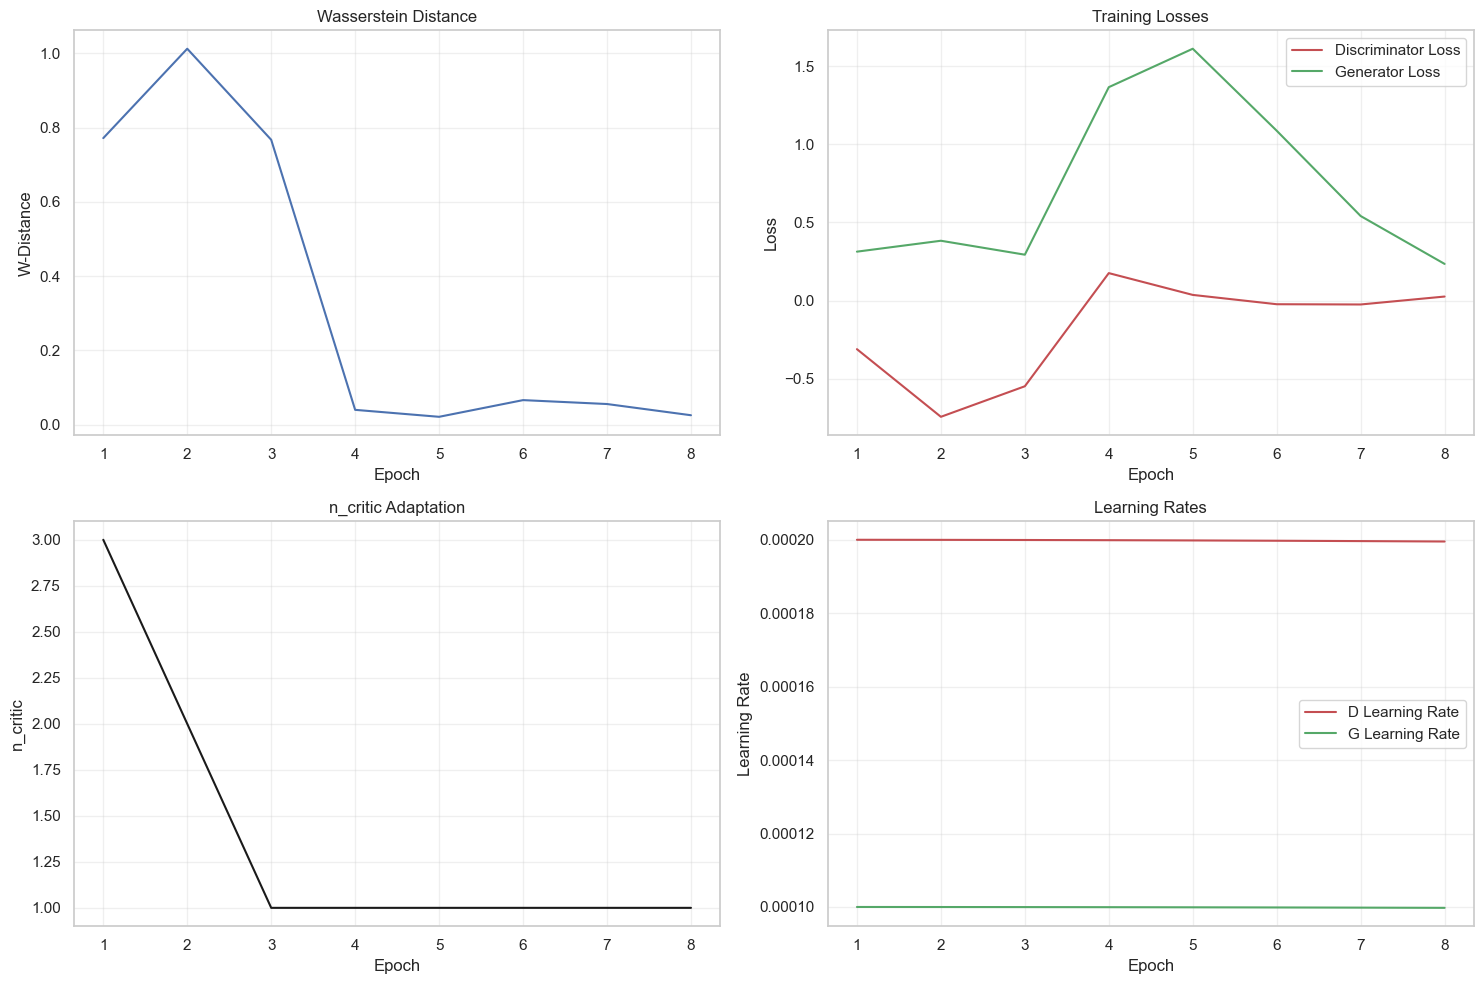

In [7]:
# Creating a GAN pipeline with GAN Config class
generator = GAN(real_df, metadata, GanConfig(epochs=250, patience=5))
# Training a GAN model with training plots
generator.fit(verbose=True)
# Generating synthetic data
synthetic_data_gan = generator.generate(synthetic_size)

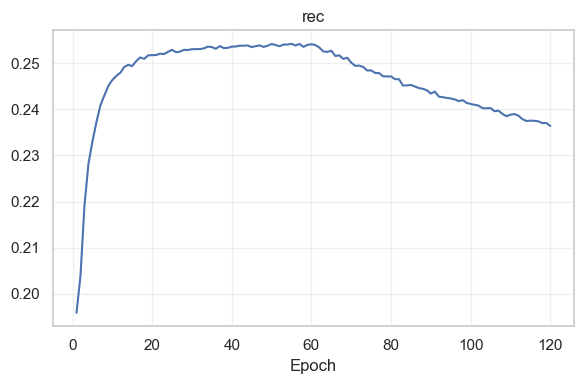

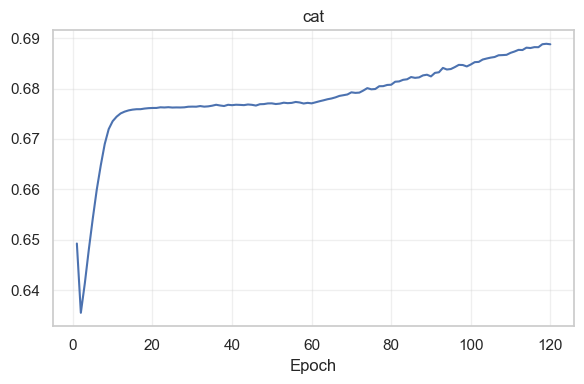

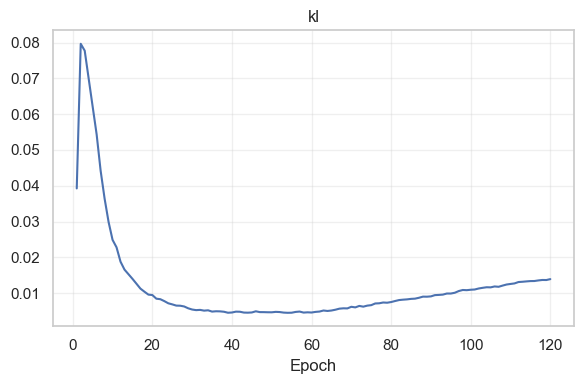

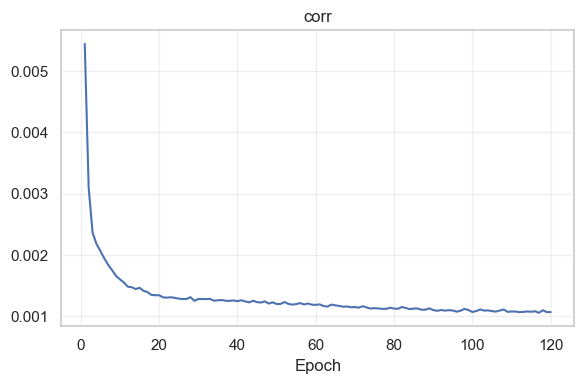

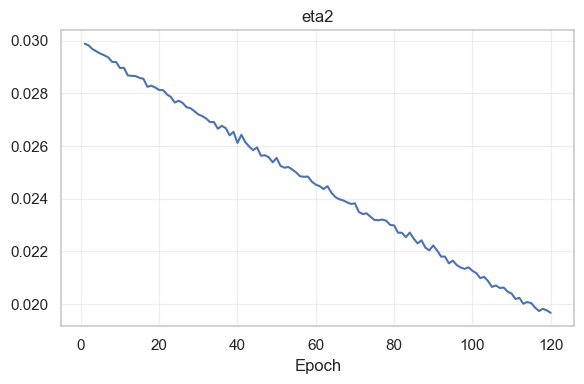

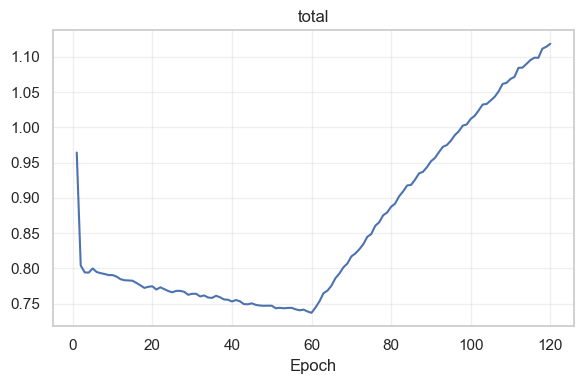

In [39]:
# Creating a VAE pipeline
vae = VAE(real_df, metadata)
# Training a VAE model with training plots
vae.fit(epochs=240, verbose=True)
# Generating synthetic data
synthetic_data_vae = vae.generate(synthetic_size)

## 4. Quality Analysis

In [63]:
# Dictionary of datasets with their names
datasets = {
    'Original': real_df,
    'GAN': synthetic_data_gan,
    'VAE': synthetic_data_vae
}

In [42]:
print("\nNumeric Columns Describe (Original)")
display(real_df[num_cols].describe())


Numeric Columns Describe (Original)


Age  Flight Distance  Inflight wifi service  \
count  103594.000000    103594.000000          103594.000000   
mean       39.380466      1189.325202               2.729753   
std        15.113125       997.297235               1.327866   
min         7.000000        31.000000               0.000000   
25%        27.000000       414.000000               2.000000   
50%        40.000000       842.000000               3.000000   
75%        51.000000      1743.000000               4.000000   
max        85.000000      4983.000000               5.000000   

       Departure or Arrival time convenient  Ease of Online booking  \
count                         103594.000000           103594.000000   
mean                               3.060081                2.756984   
std                                1.525233                1.398934   
min                                0.000000                0.000000   
25%                                2.000000                2.000000   
50%                                3.000000                3.000000   
75%                                4.000000                4.000000   
max                                5.000000                5.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  103594.000000   103594.000000    103594.000000  103594.000000   
mean        2.977026        3.202126         3.250497       3.439765   
std         1.277723        1.329401         1.349433       1.318896   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max         5.000000        5.000000         5.000000       5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           103594.000000     103594.000000     103594.000000   
mean                 3.358341          3.382609          3.351401   
std                  1.333030          1.288284          1.315409   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service    Cleanliness  \
count     103594.000000    103594.000000     103594.000000  103594.000000   
mean           3.631687         3.304323          3.640761       3.286397   
std            1.181051         1.265396          1.175603       1.312194   
min            1.000000         0.000000          0.000000       0.000000   
25%            3.000000         3.000000          3.000000       2.000000   
50%            4.000000         3.000000          4.000000       3.000000   
75%            5.000000         4.000000          5.000000       4.000000   
max            5.000000         5.000000          5.000000       5.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count               103594.000000             103594.000000  
mean                    14.747939                 15.178678  
std                     38.116737                 38.698682  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                   1592.000000               1584.000000

#### Статистичні метрики оригінального та синтетичних датасетів

In [43]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, entropy, wasserstein_distance, chi2_contingency
from sklearn.metrics import mean_absolute_error
from pandas.api.types import is_numeric_dtype

# -------------------------------------------------
# helpers
# -------------------------------------------------
def _kl_divergence(hist_ref, hist_cmp, eps=1e-10):
    """Symmetric KL with an ε-smoothing to avoid log(0)."""
    return 0.5 * (
        entropy(hist_ref + eps, hist_cmp + eps) +
        entropy(hist_cmp + eps, hist_ref + eps)
    )

def _safe_hist(series, bins=50):
    """Histogram with fixed bin-edges (for KL and Wasserstein)."""
    counts, edges = np.histogram(series, bins=bins, density=True)
    return counts, edges

def _value_counts(series):
    """Consistent index type (str) so union / reindex is stable."""
    return series.astype('object').astype(str).value_counts()

# -------------------------------------------------
# numeric metrics
# -------------------------------------------------
numeric_metrics = []

for col, meta in metadata.items():
    if meta.data_type not in {DataType.INTEGER, DataType.DECIMAL}:
        continue
    if not is_numeric_dtype(real_df[col]):                 # guard against funky dtype
        continue

    real = real_df[col].dropna().to_numpy()
    gan  = synthetic_data_gan[col].dropna().to_numpy()
    vae  = synthetic_data_vae[col].dropna().to_numpy()

    if len(real) == 0:                                     # no data in reference -> skip
        continue

    # Wasserstein
    w_gan, w_vae = wasserstein_distance(real, gan), wasserstein_distance(real, vae)

    # KS
    ks_gan, ks_vae = ks_2samp(real, gan), ks_2samp(real, vae)

    # KL (symmetrised) on equal bins
    hist_r, bins  = _safe_hist(real)
    hist_g, _     = np.histogram(gan, bins=bins, density=True)
    hist_v, _     = np.histogram(vae, bins=bins, density=True)
    kl_gan, kl_vae = _kl_divergence(hist_r, hist_g), _kl_divergence(hist_r, hist_v)

    numeric_metrics.append({
        "field": col,
        "W_gan":  w_gan,
        "KS_gan_stat": ks_gan.statistic,  "KS_gan_p": ks_gan.pvalue,
        "KL_gan": kl_gan,
        "W_vae":  w_vae,
        "KS_vae_stat": ks_vae.statistic,  "KS_vae_p": ks_vae.pvalue,
        "KL_vae": kl_vae,
    })

df_numeric = pd.DataFrame(numeric_metrics).set_index("field")

# -------------------------------------------------
# categorical / boolean metrics
# -------------------------------------------------
categorical_metrics = []

for col, meta in metadata.items():
    if meta.data_type not in {DataType.CATEGORICAL, DataType.BOOLEAN}:
        continue

    real_ct = _value_counts(real_df[col])
    gan_ct  = _value_counts(synthetic_data_gan[col])
    vae_ct  = _value_counts(synthetic_data_vae[col])

    # Common support
    cats = sorted(set(real_ct.index) | set(gan_ct.index) | set(vae_ct.index))

    # MAE on counts
    mae_gan = mean_absolute_error(real_ct.reindex(cats, fill_value=0),
                                  gan_ct.reindex(cats, fill_value=0))
    mae_vae = mean_absolute_error(real_ct.reindex(cats, fill_value=0),
                                  vae_ct.reindex(cats, fill_value=0))

    # χ² contingency
    cont_gan = np.vstack([
        real_ct.reindex(cats, fill_value=0),
        gan_ct.reindex(cats,  fill_value=0)
    ])
    cont_vae = np.vstack([
        real_ct.reindex(cats, fill_value=0),
        vae_ct.reindex(cats,  fill_value=0)
    ])

    chi_g_stat, chi_g_p, _, _ = chi2_contingency(cont_gan)
    chi_v_stat, chi_v_p, _, _ = chi2_contingency(cont_vae)

    categorical_metrics.append({
        "field": col,
        "MAE_gan": mae_gan,
        "Chi2_gan_stat": chi_g_stat, "Chi2_gan_p": chi_g_p,
        "MAE_vae": mae_vae,
        "Chi2_vae_stat": chi_v_stat, "Chi2_vae_p": chi_v_p,
    })

df_categorical = pd.DataFrame(categorical_metrics).set_index("field")

# -------------------------------------------------
# display / further analysis
# -------------------------------------------------
print("⋯ Numeric-column quality metrics")
display(df_numeric.sort_index())

print("⋯ Categorical / boolean-column quality metrics")
display(df_categorical.sort_index())

⋯ Numeric-column quality metrics


W_gan  KS_gan_stat  KS_gan_p  \
field                                                                     
Age                                     7.727778     0.243571       0.0   
Arrival Delay in Minutes               11.390218     0.157690       0.0   
Baggage handling                        0.537266     0.163227       0.0   
Checkin service                         0.562367     0.186771       0.0   
Cleanliness                             0.443990     0.161521       0.0   
Departure Delay in Minutes             10.586399     0.141370       0.0   
Departure or Arrival time convenient    0.620492     0.191122       0.0   
Ease of Online booking                  0.449989     0.142819       0.0   
Flight Distance                       452.902778     0.214170       0.0   
Food and drink                          0.445544     0.170249       0.0   
Gate location                           0.606605     0.205515       0.0   
Inflight entertainment                  0.288190     0.124566       0.0   
Inflight service                        0.511296     0.155909       0.0   
Inflight wifi service                   0.382719     0.138475       0.0   
Leg room service                        0.510926     0.211216       0.0   
On-board service                        0.372367     0.135438       0.0   
Online boarding                         0.361702     0.130515       0.0   
Seat comfort                            0.452002     0.142875       0.0   

                                        KL_gan       W_vae  KS_vae_stat  \
field                                                                     
Age                                   1.965775    1.283053     0.045485   
Arrival Delay in Minutes              0.258214   14.751284     0.101967   
Baggage handling                      0.422929    0.062086     0.020830   
Checkin service                       0.594902    0.039367     0.017326   
Cleanliness                           0.344740    0.039159     0.014001   
Departure Delay in Minutes            0.231189   16.032795     0.111754   
Departure or Arrival time convenient  0.578834    0.090774     0.031097   
Ease of Online booking                0.285373    0.128938     0.051609   
Flight Distance                       1.311685  132.815061     0.085124   
Food and drink                        0.332989    0.065369     0.027089   
Gate location                         0.602518    0.143866     0.046835   
Inflight entertainment                0.125605    0.055441     0.023760   
Inflight service                      0.411690    0.087176     0.039869   
Inflight wifi service                 0.265092    0.232054     0.095118   
Leg room service                      0.648409    0.051877     0.022496   
On-board service                      0.200642    0.050049     0.022048   
Online boarding                       0.228594    0.060953     0.029144   
Seat comfort                          0.238562    0.060383     0.023655   

                                           KS_vae_p    KL_vae  
field                                                          
Age                                    4.577632e-61  0.024570  
Arrival Delay in Minutes              1.032610e-305  0.043740  
Baggage handling                       3.839385e-13  0.004796  
Checkin service                        3.179324e-09  0.001897  
Cleanliness                            3.587936e-06  0.001655  
Departure Delay in Minutes             0.000000e+00  0.048413  
Departure or Arrival time convenient   9.138824e-29  0.007790  
Ease of Online booking                 1.668509e-78  0.015702  
Flight Distance                       4.878460e-213  0.063090  
Food and drink                         6.246883e-22  0.006187  
Gate location                          1.009296e-64  0.020643  
Inflight entertainment                 5.697736e-17  0.004008  
Inflight service                       5.180607e-47  0.009067  
Inflight wifi service                 5.332912e-266  0.063751  
Leg room service 

⋯ Categorical / boolean-column quality metrics


MAE_gan  Chi2_gan_stat    Chi2_gan_p       MAE_vae  \
field                                                                     
Class           17864.666667    3850.606739  0.000000e+00  18737.333333   
Customer Type   26797.000000    6961.001044  0.000000e+00  26797.000000   
Gender          26797.000000     150.012955  1.722377e-34  26797.000000   
Type of Travel  26797.000000    4305.624960  0.000000e+00  26797.000000   
is_satisfied    26797.000000     101.216831  8.244579e-24  26797.000000   

                Chi2_vae_stat     Chi2_vae_p  
field                                         
Class             3817.429372   0.000000e+00  
Customer Type     1196.271516  3.940975e-262  
Gender               0.091930   7.617372e-01  
Type of Travel     300.030546   3.244266e-67  
is_satisfied        81.906829   1.426555e-19

#### Генерування даних строкових типів

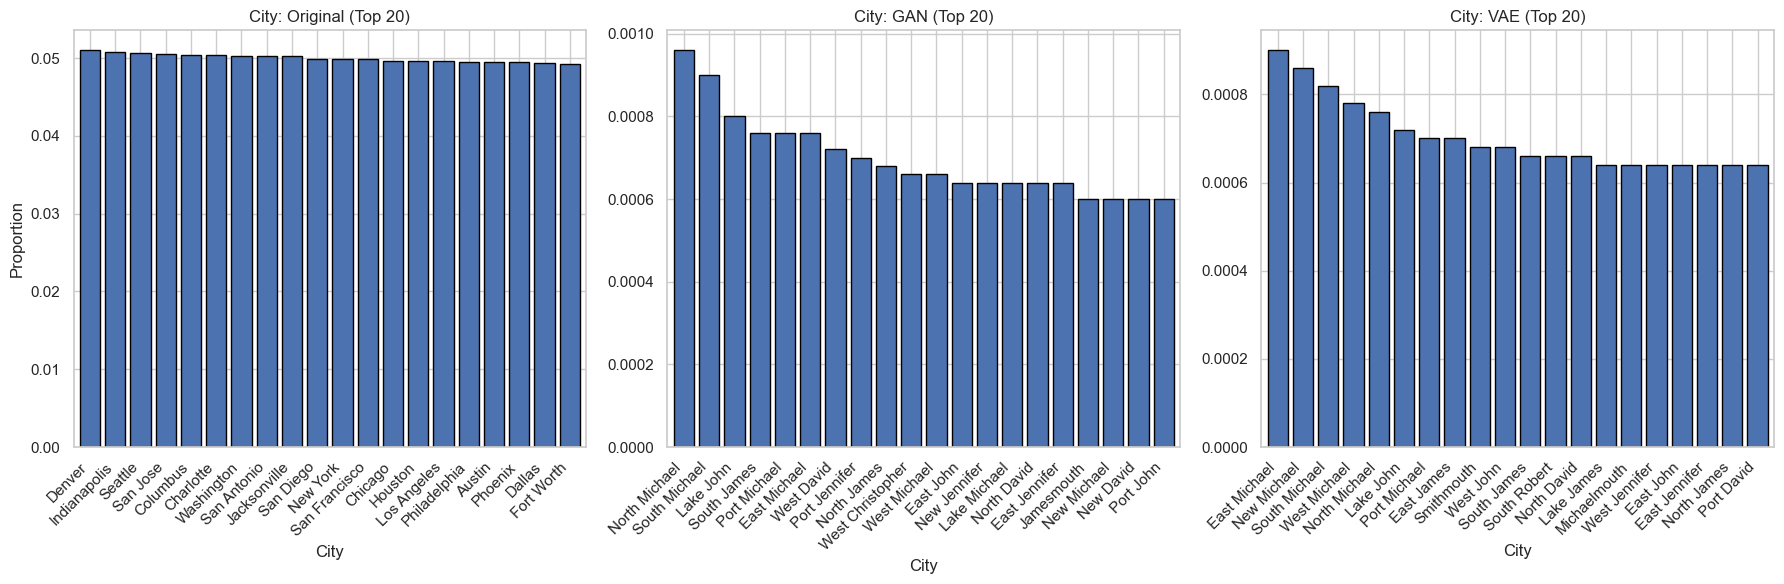

In [44]:
# Get value counts for each dataset's city column
orig = real_df['City'].value_counts(normalize=True).nlargest(20)
gan = synthetic_data_gan['City'].value_counts(normalize=True).nlargest(20)
vae = synthetic_data_vae['City'].value_counts(normalize=True).nlargest(20)

# Create 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Original distribution
orig.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black')
axes[0].set_title('City: Original (Top 20)')
axes[0].set_ylabel('Proportion')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot GAN distribution
gan.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
axes[1].set_title('City: GAN (Top 20)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

# Plot VAE distribution
vae.plot(kind='bar', ax=axes[2], width=0.8, edgecolor='black')
axes[2].set_title('City: VAE (Top 20)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Порівняння розподілів числових колонок у оригінальному та синтетичних датасетах

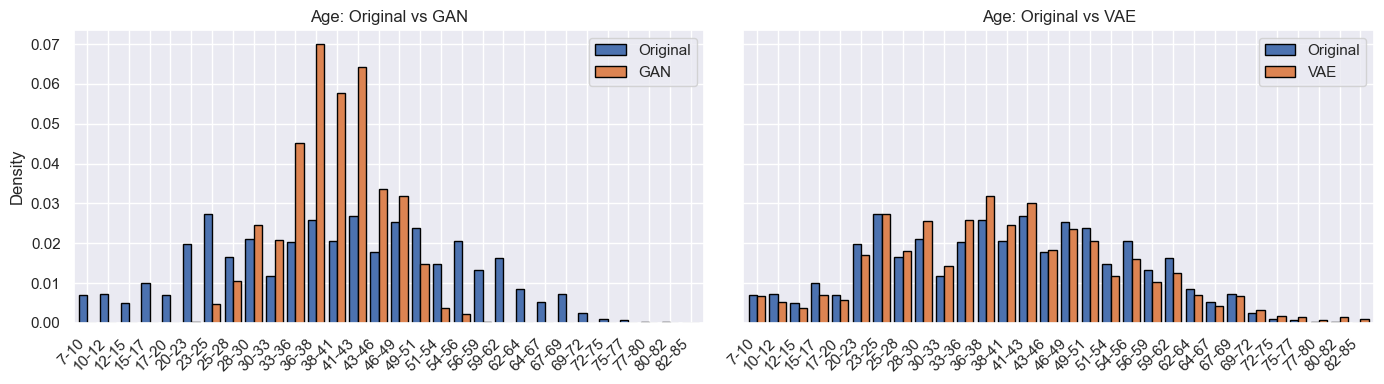

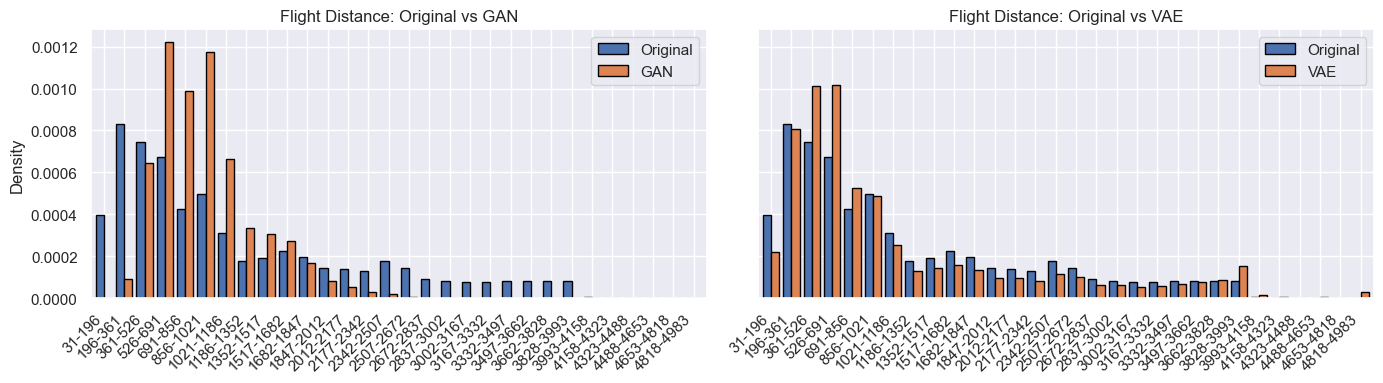

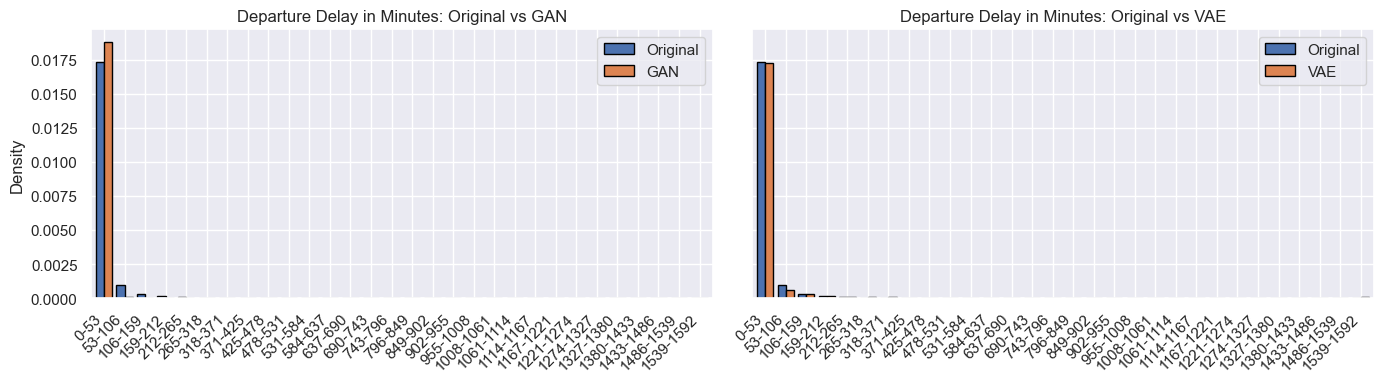

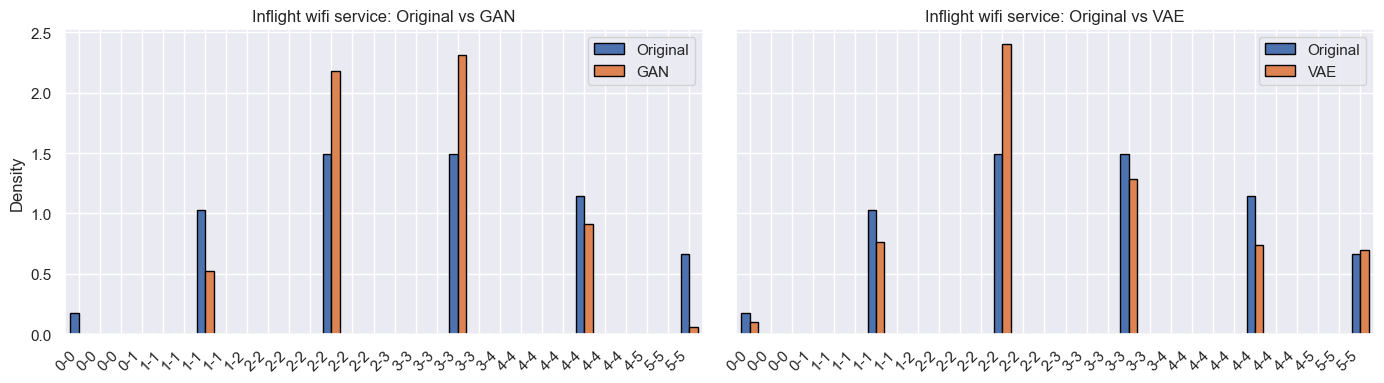

In [54]:
for col in ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Inflight wifi service']:
    orig_vals = real_df[col].dropna().values
    gan_vals  = synthetic_data_gan[col].dropna().values
    vae_vals  = synthetic_data_vae[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts,  _ = np.histogram(gan_vals,  bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins)-1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({'Original': orig_counts, 'GAN': gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({'Original': orig_counts, 'VAE': vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black')
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel('Density')

    df_ov.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.legend()
    plt.tight_layout()
    plt.show()

#### Порівняння розподілів категоріальних колонок у оригінальному та синтетичних датасетах

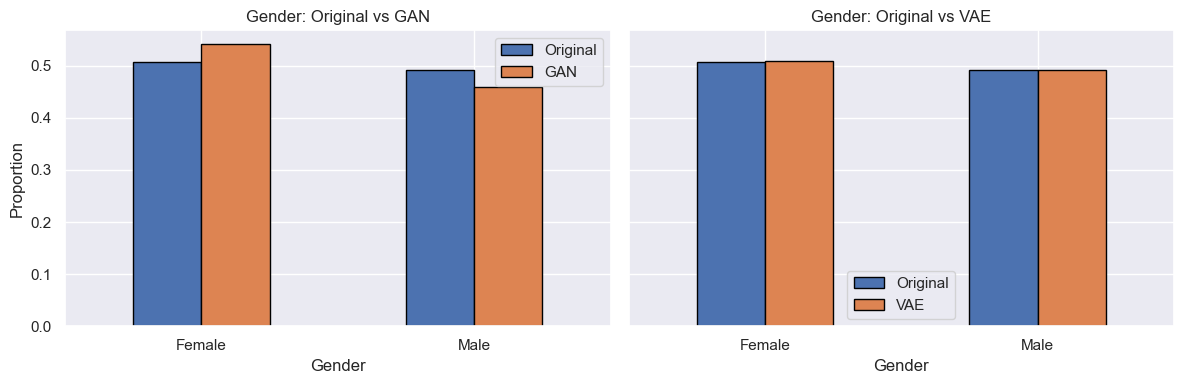

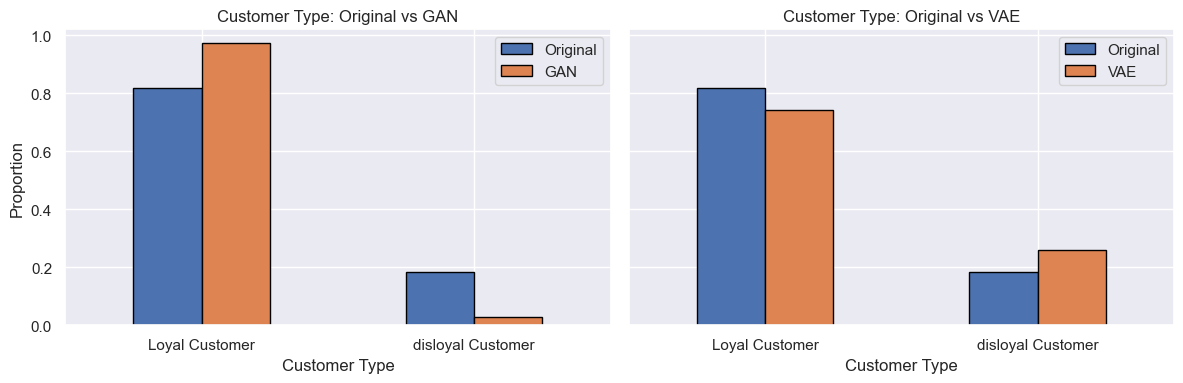

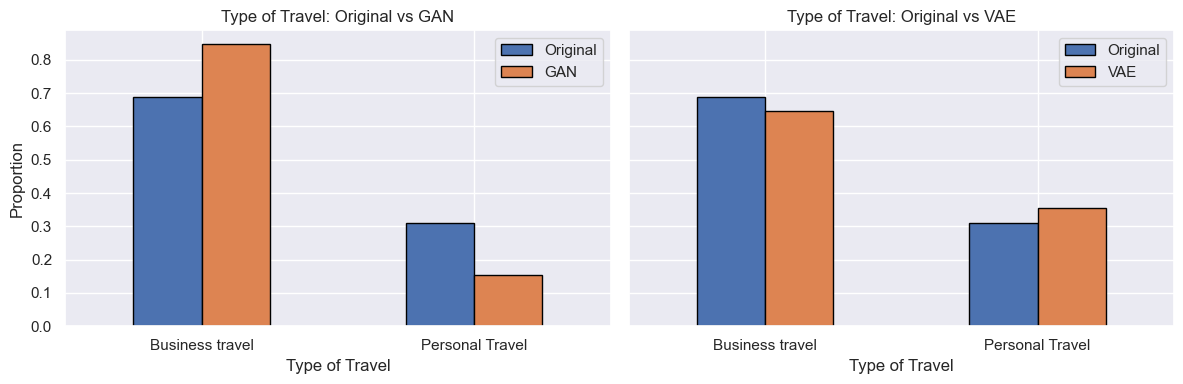

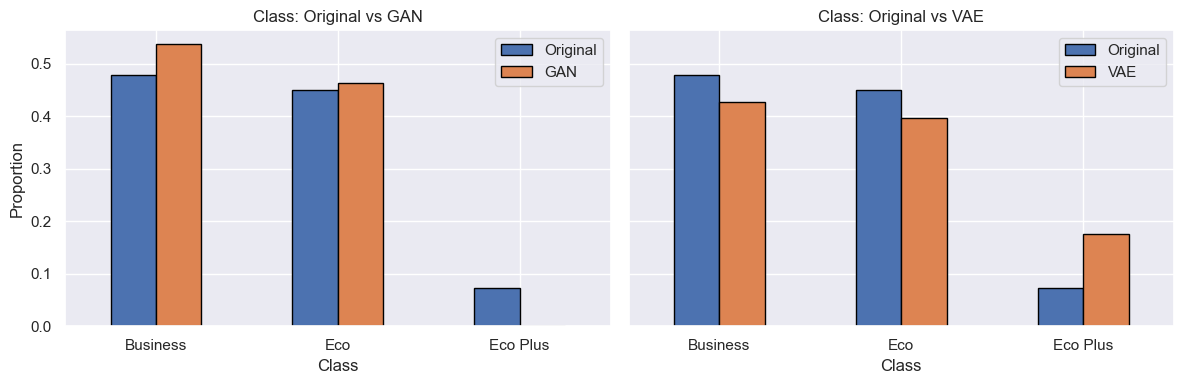

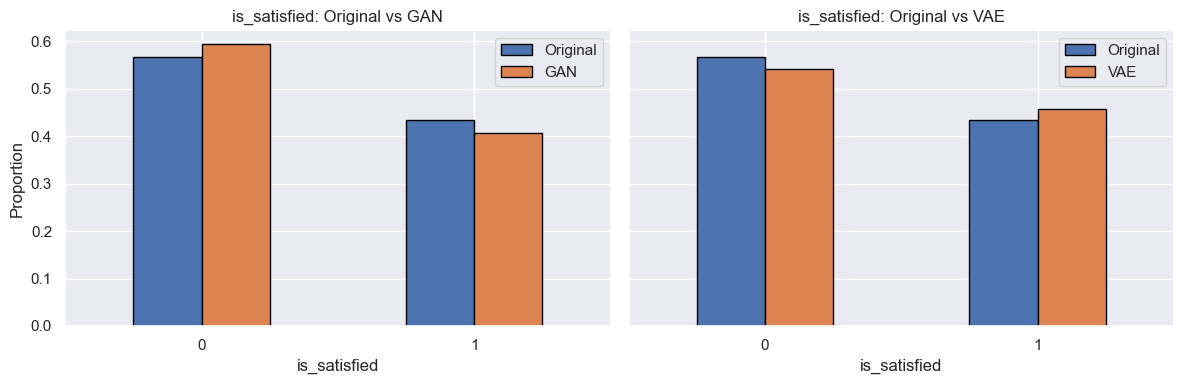

In [55]:
for col in cat_bool_cols:
    # Prepare normalized proportions as strings to avoid mixed-type ordering issues
    orig = real_df[col].fillna('NaN').astype(str).value_counts(normalize=True).sort_index()
    gan  = synthetic_data_gan[col].fillna('NaN').astype(str).value_counts(normalize=True).reindex(orig.index, fill_value=0)
    vae  = synthetic_data_vae[col].fillna('NaN').astype(str).value_counts(normalize=True).reindex(orig.index, fill_value=0)

    # Build DataFrames for side-by-side bar plots
    df_gan_counts = pd.DataFrame({'Original': orig, 'GAN': gan})
    df_vae_counts = pd.DataFrame({'Original': orig, 'VAE': vae})

    # Create 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Plot Original vs GAN
    df_gan_counts.plot(kind='bar', ax=axes[0], edgecolor='black')
    axes[0].set_title(f'{col}: Original vs GAN')
    axes[0].set_ylabel('Proportion')

    # Plot Original vs VAE
    df_vae_counts.plot(kind='bar', ax=axes[1], edgecolor='black')
    axes[1].set_title(f'{col}: Original vs VAE')

    # Tidy up tick labels
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.legend()

    plt.tight_layout()
    plt.show()


#### Визначаємо службові методи для створення кореляційних матриць (numeric-numeric та categorical-numeric)

In [9]:
from pandas.core.dtypes.common import is_numeric_dtype


def correlation_num_to_num_matrix_plot(df1, df2, columns, title_prefix=""):
    """
    Plots numeric-numeric correlations for Real vs Synthetic and their absolute difference.
    """
    corr_orig = df1[columns].corr()
    corr_gan  = df2[columns].corr()
    diff_gan  = (corr_orig - corr_gan).abs()

    # 2) Original heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_orig, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title("Numeric-Numeric Correlation — Original")
    plt.tight_layout()
    plt.show()

    # 3) GAN heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_gan, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title(f"Numeric-Numeric Correlation — {title_prefix}")
    plt.tight_layout()
    plt.show()

    # 4) Absolute-difference heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(diff_gan, vmin=0, vmax=1, cmap="rocket_r", annot=False, fmt=".2f")
    plt.title(f"Absolute Difference |Original – {title_prefix}|")
    plt.tight_layout()
    plt.show()

def correlation_ratio(categories, values):
    df = values.to_frame(name="x").join(categories.rename("g"))
    df = df.dropna(subset=["x", "g"])
    grand_mean = df["x"].mean()
    ss_between = sum(
        grp["x"].count() * (grp["x"].mean() - grand_mean)**2
        for _, grp in df.groupby("g")
    )
    ss_total = ((df["x"] - grand_mean)**2).sum()
    return ss_between / ss_total if ss_total > 0 else np.nan

def correlation_cat_num_matrix_plot(df_real, df_syn, num_cols, cat_cols,
                                    title_prefix="", squared=False):
    def _eta(col_cat, col_num):
        if not is_numeric_dtype(col_num) or col_num.isna().all():
            return np.nan
        overall = col_num.mean()
        stats = col_num.groupby(col_cat, dropna=False).agg(['count', 'mean'])
        ss_between = (stats['count'] * (stats['mean'] - overall) ** 2).sum()
        ss_total   = ((col_num - overall) ** 2).sum()
        val = ss_between / ss_total if ss_total > 0 else np.nan
        return val if squared else np.sqrt(val)

    eta_real = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=float)
    eta_syn  = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=float)

    for c in cat_cols:
        for n in num_cols:
            eta_real.loc[c, n] = _eta(df_real[c], df_real[n])
            eta_syn.loc[c, n]  = _eta(df_syn[c],  df_syn[n])

    eta_diff = (eta_real - eta_syn).abs()

    for mat, ttl in zip([eta_real, eta_syn, eta_diff],
                        ["η Real" if not squared else "η² Real",
                         "η Synthetic" if not squared else "η² Synthetic",
                         "Abs diff"]):
        fig, ax = plt.subplots(figsize=(1.5*len(num_cols),
                                        0.5*len(cat_cols)+3))
        sns.heatmap(mat, mask=mat.isna(), annot=True, fmt=".2f",
                    xticklabels=num_cols, yticklabels=cat_cols,
                    cmap="rocket_r", vmin=0, vmax=1,
                    cbar_kws={'label': 'η' if not squared else 'η²'},
                    ax=ax)
        ax.set_title(f"{ttl} ({title_prefix})")
        plt.tight_layout()
        plt.show()

    return eta_real, eta_syn, eta_diff

#### Порівняння кореляційних матриць числових колонок у оригінальному та синтетичних датасетах

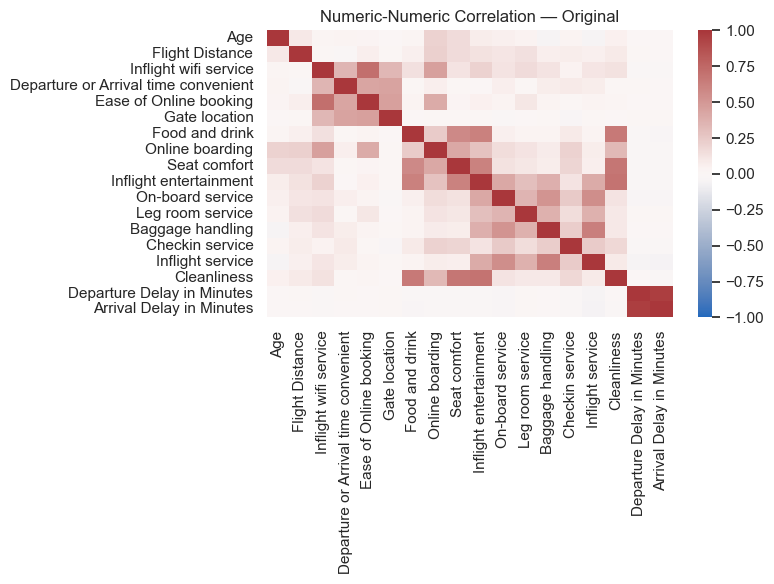

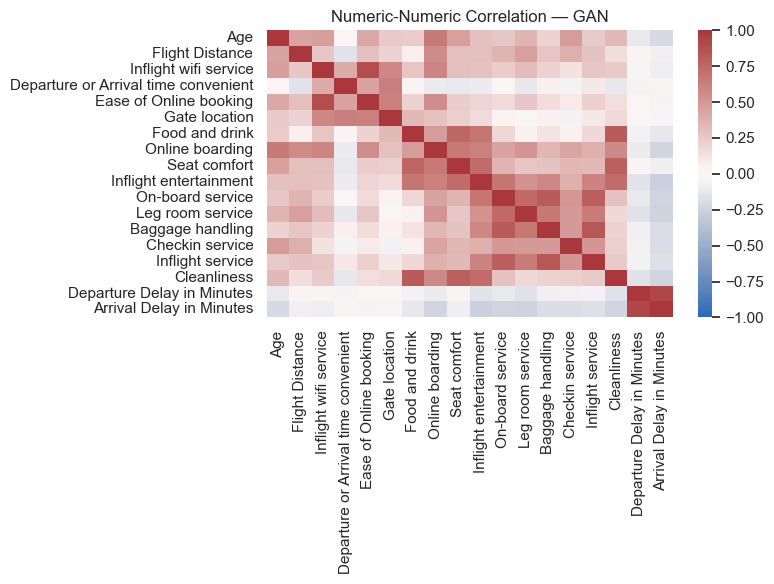

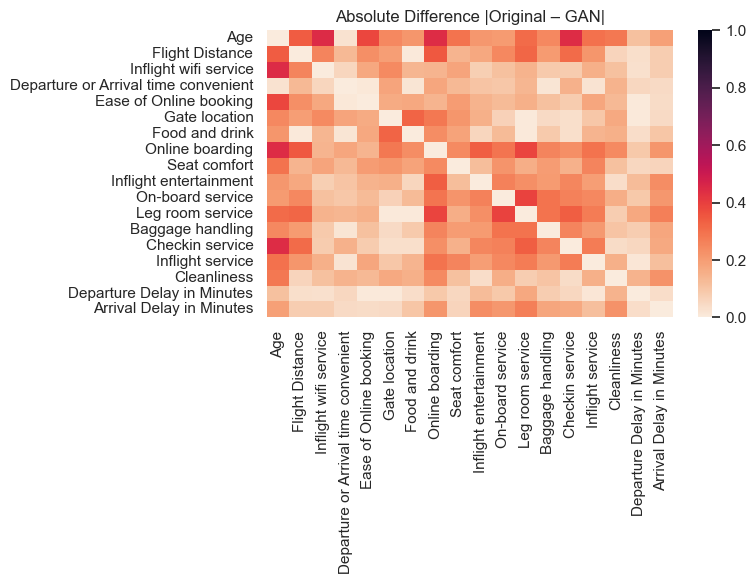

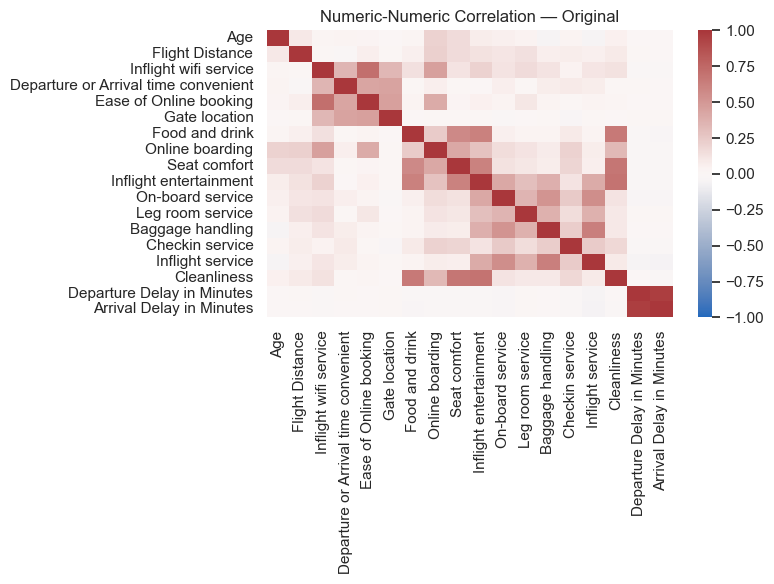

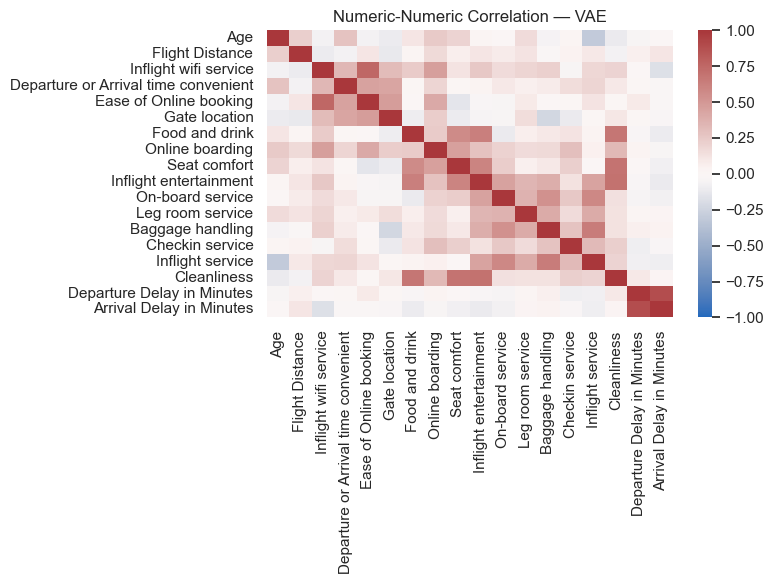

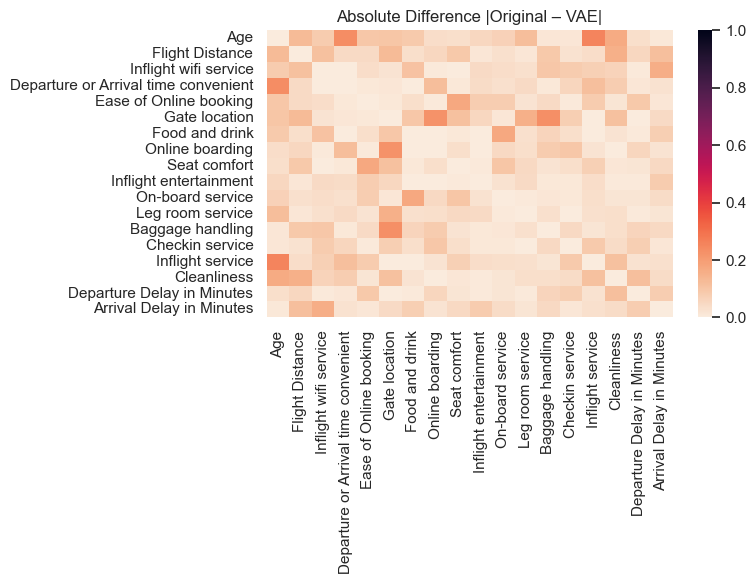

In [38]:
correlation_num_to_num_matrix_plot(real_df, synthetic_data_gan, num_cols, "GAN")
correlation_num_to_num_matrix_plot(real_df, synthetic_data_vae, num_cols, "VAE")

#### Порівняння кореляційних матриць категоріальних колонок до числових у оригінальному та синтетичних датасетах

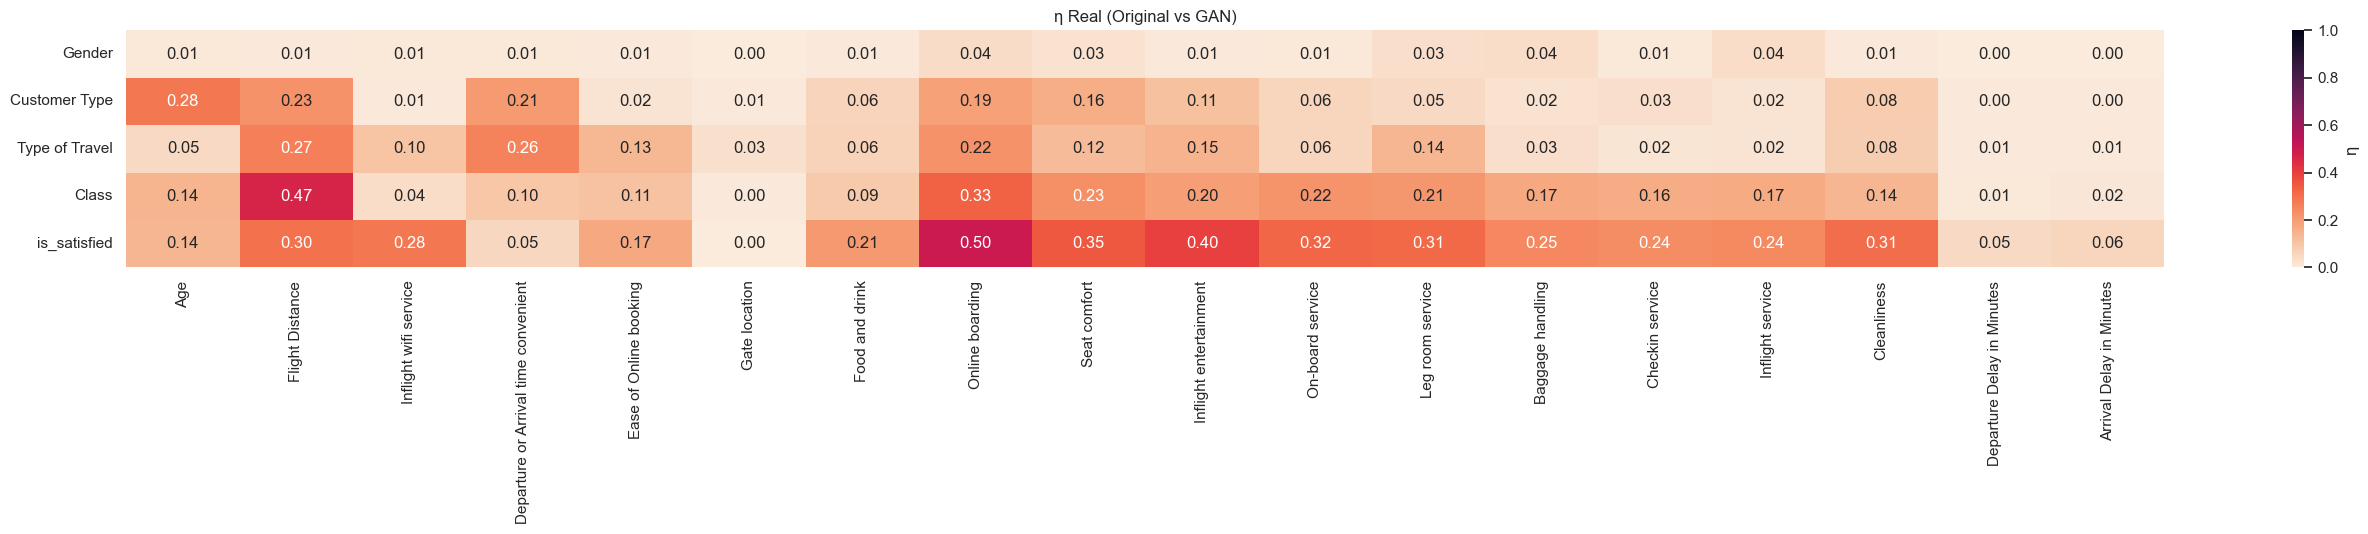

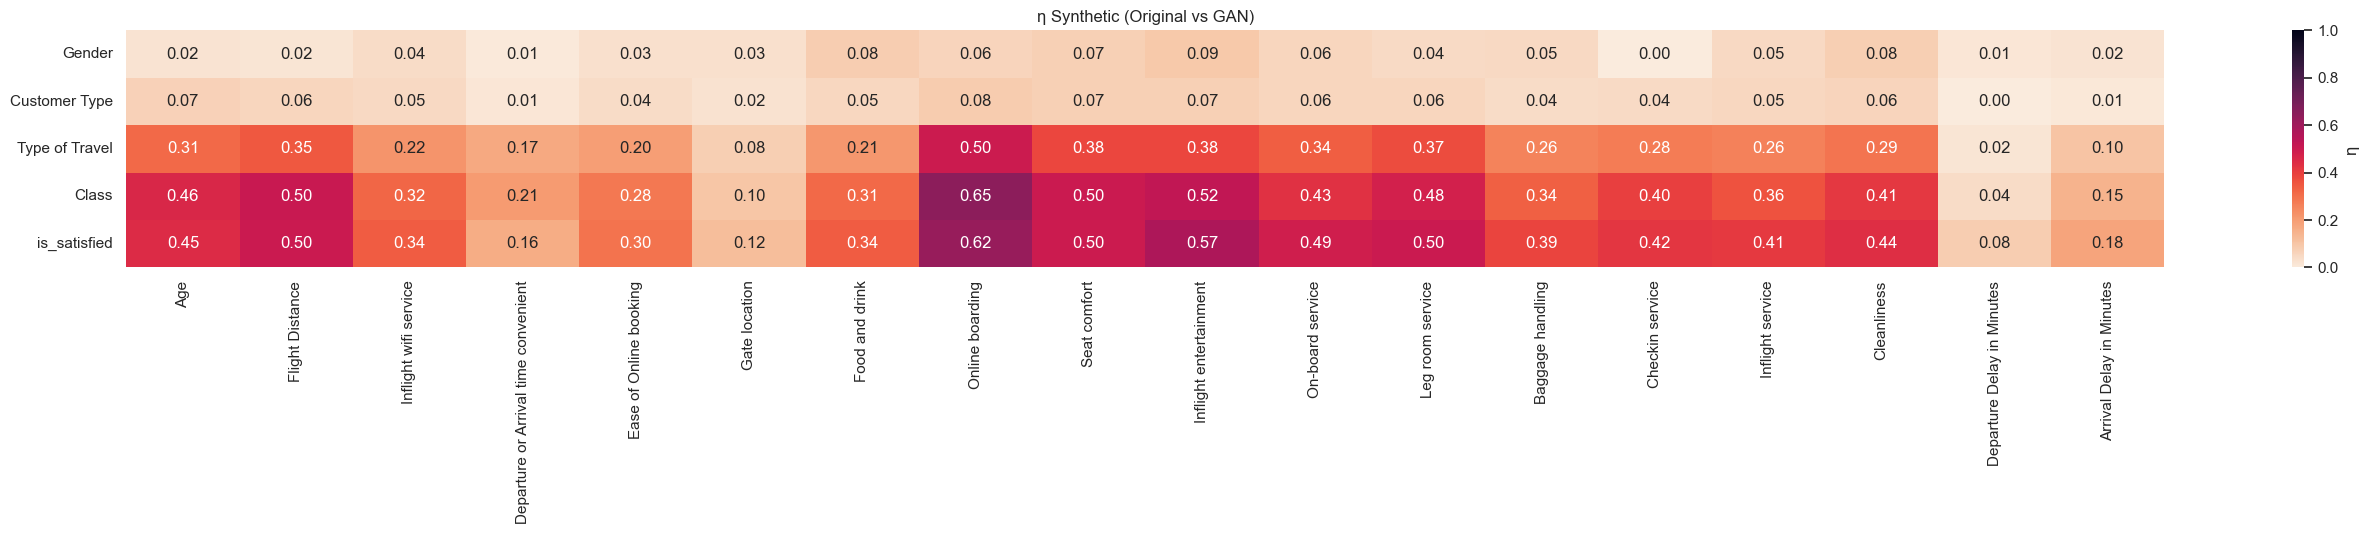

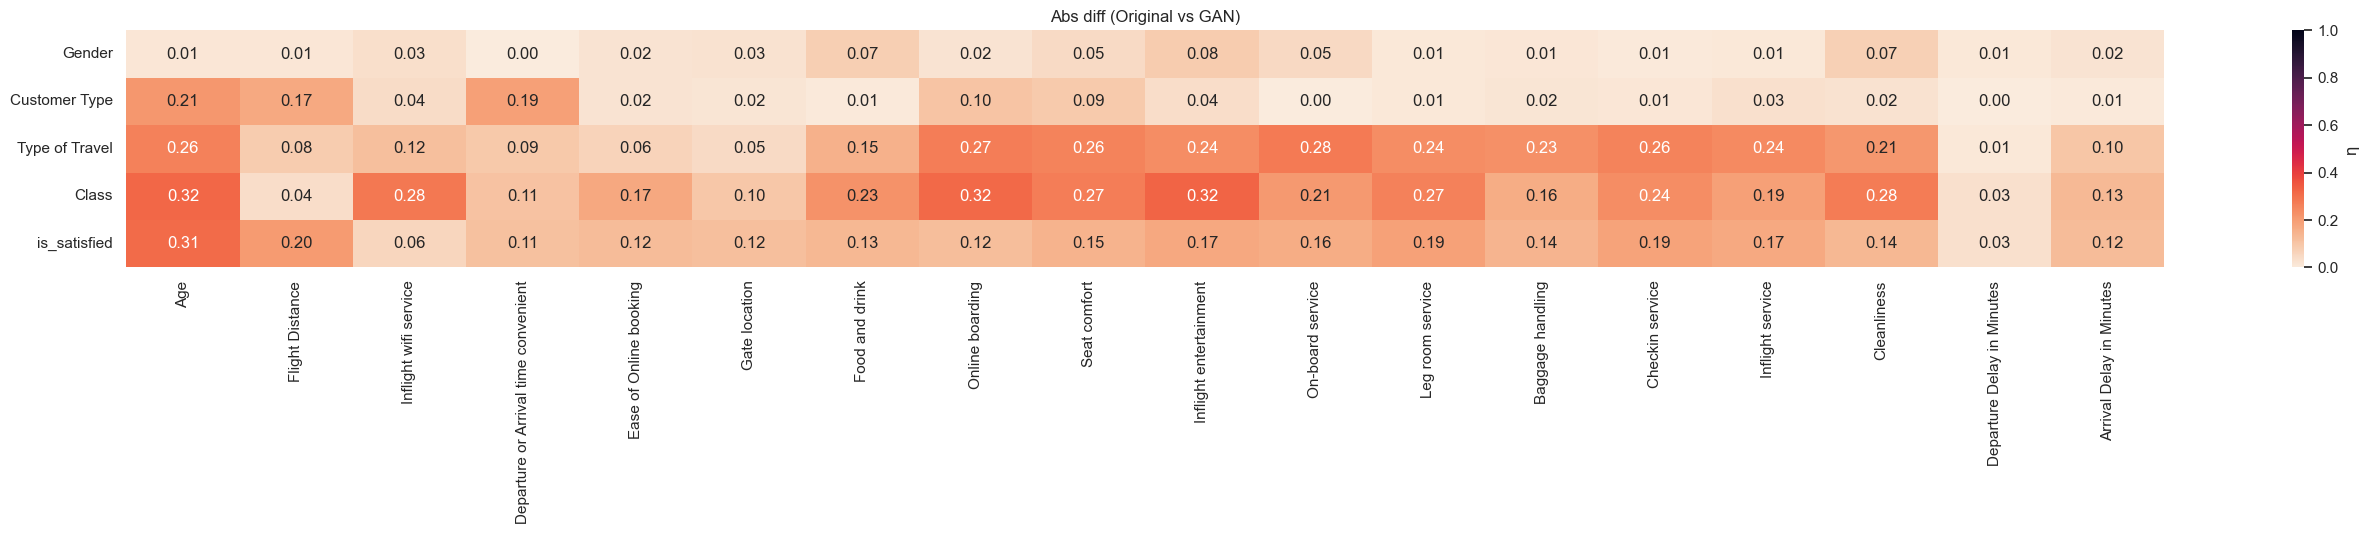

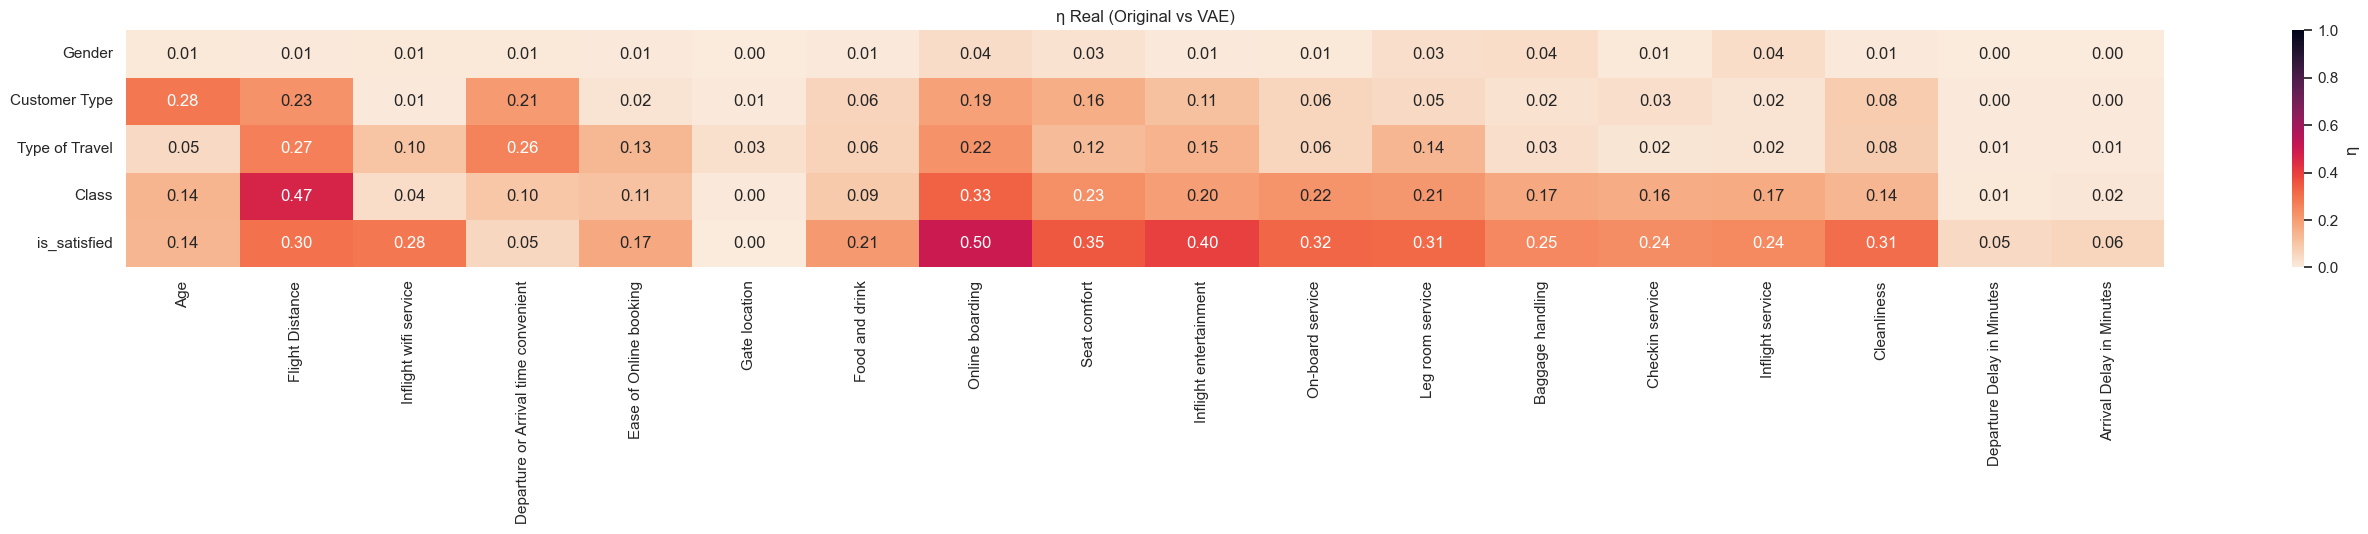

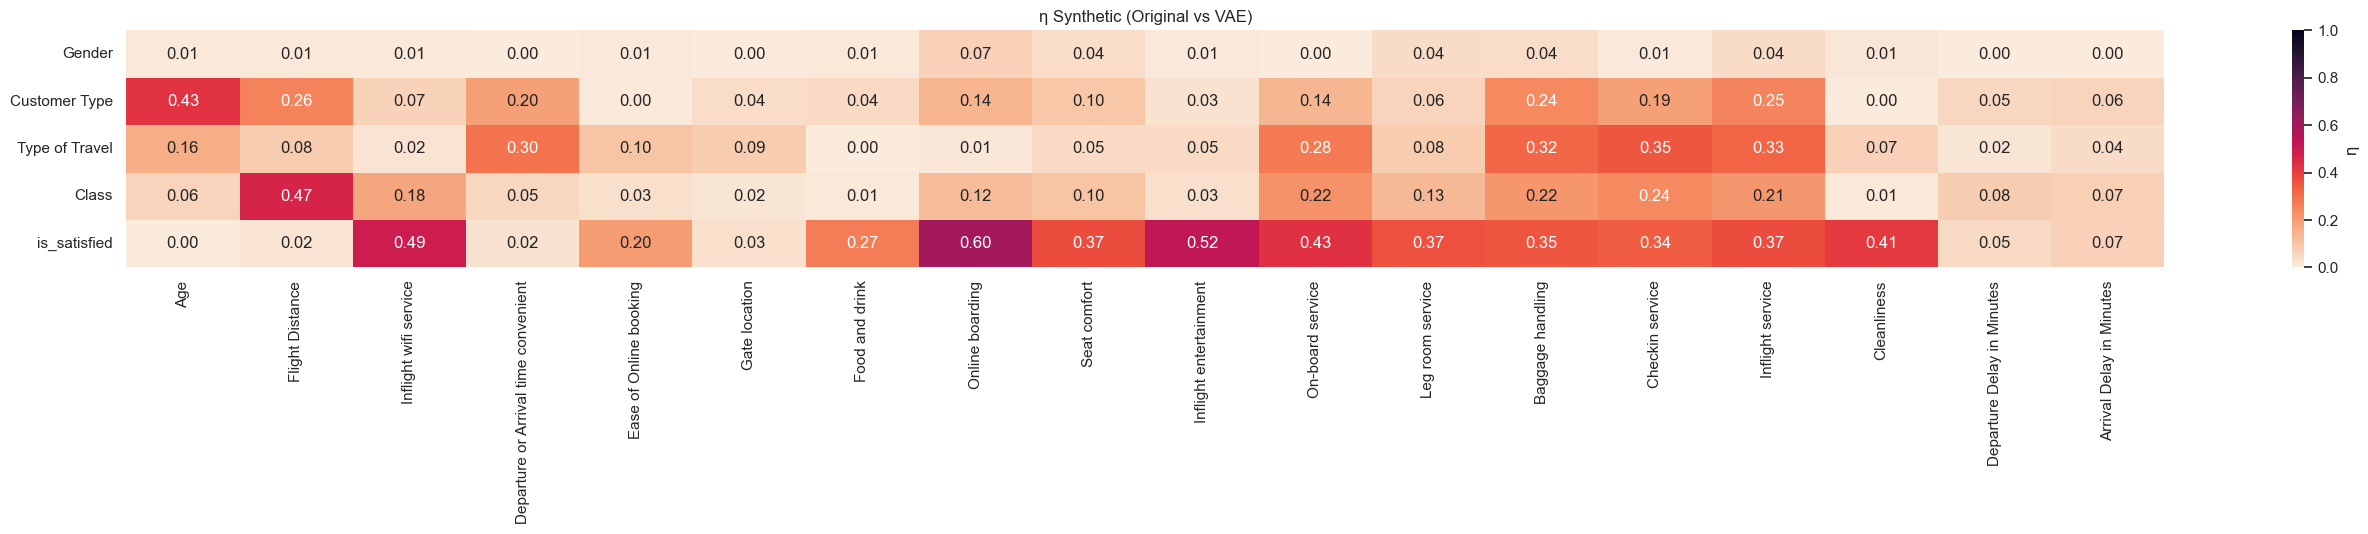

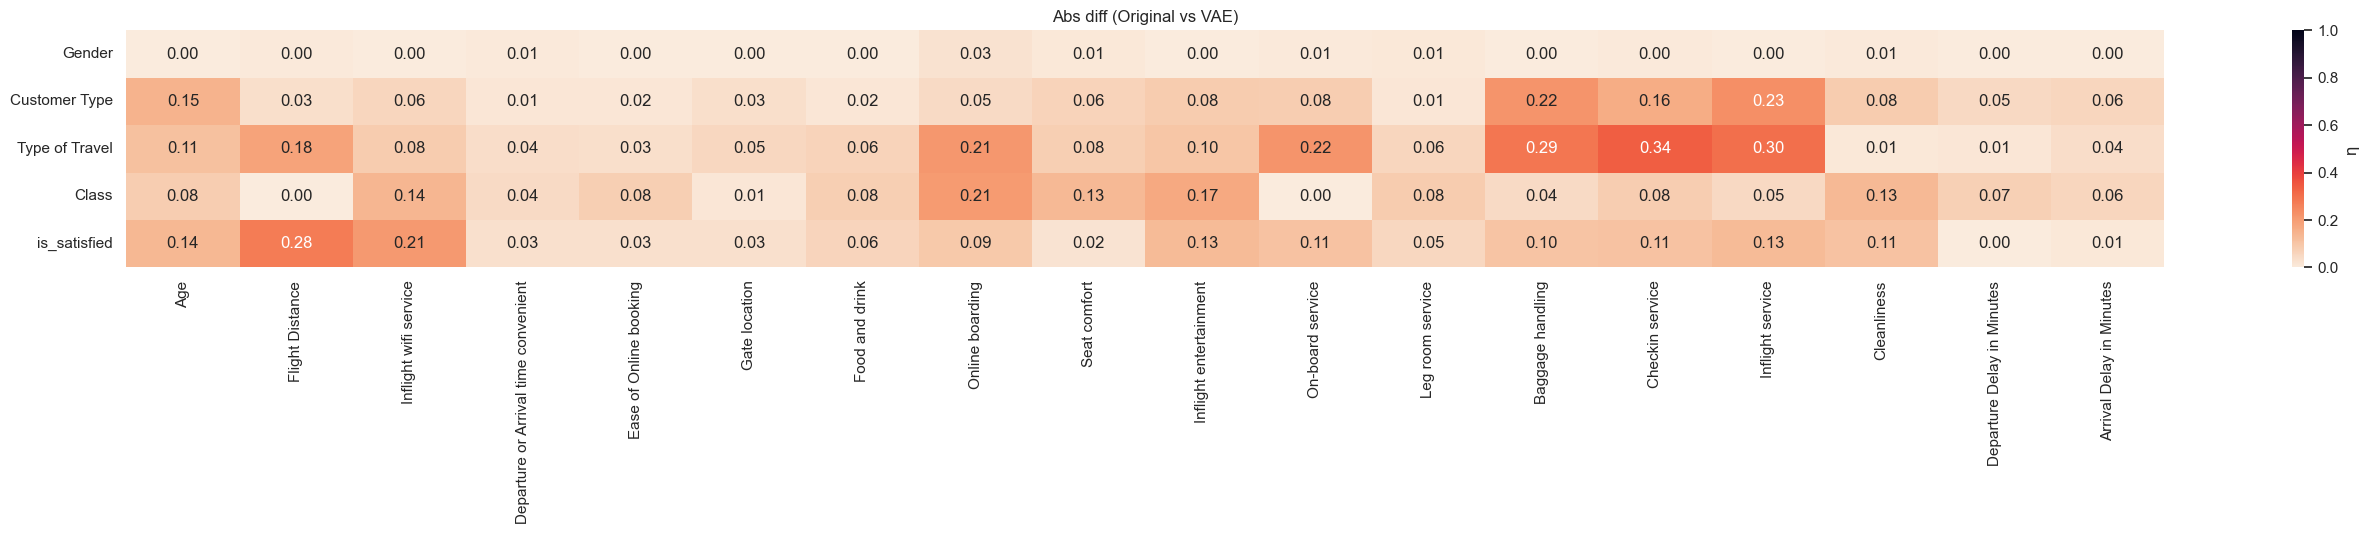

In [48]:
eta_gan = correlation_cat_num_matrix_plot(real_df, synthetic_data_gan, num_cols, cat_bool_cols, "Original vs GAN")
eta_vae = correlation_cat_num_matrix_plot(real_df, synthetic_data_vae, num_cols, cat_bool_cols, "Original vs VAE")

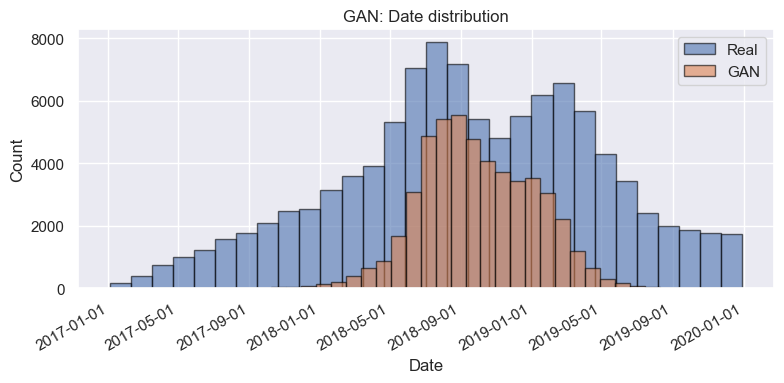

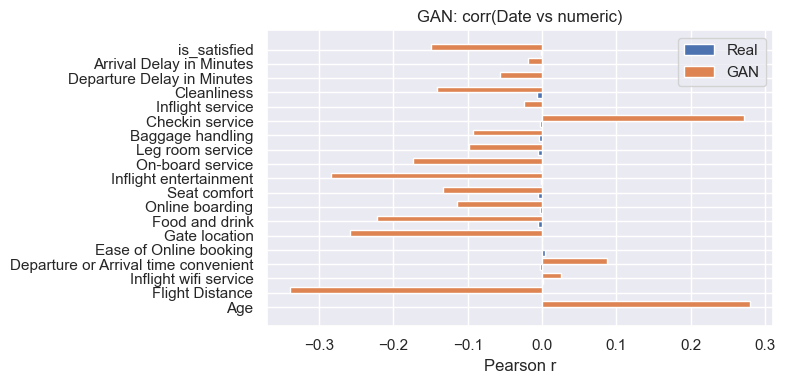

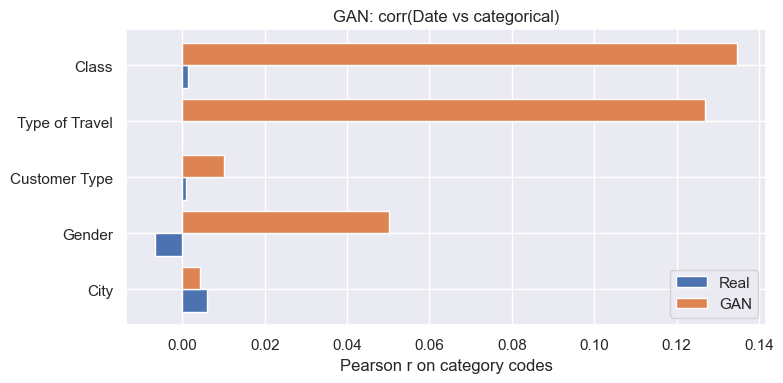

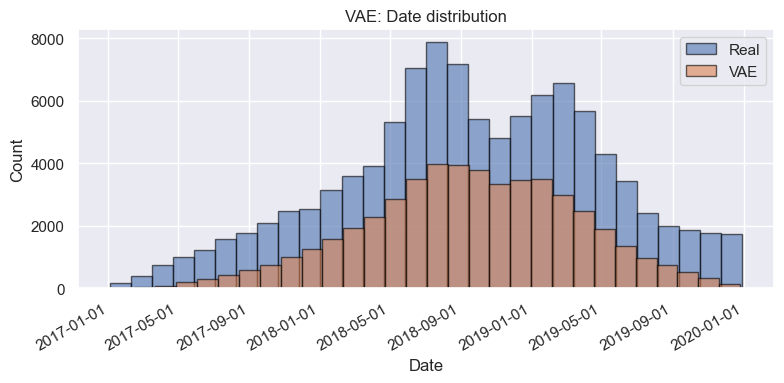

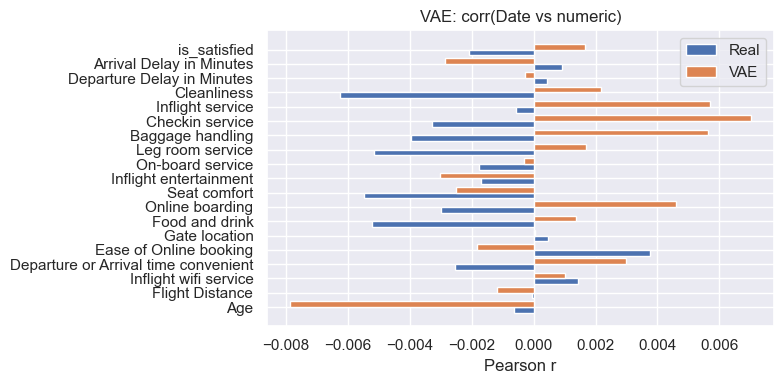

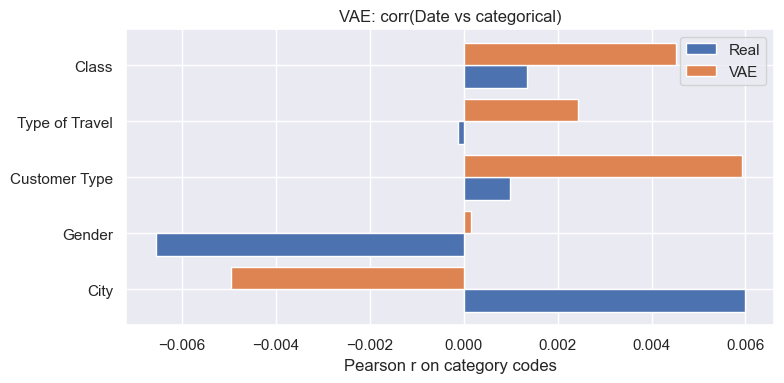

In [66]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# assume real_df, synthetic_data_gan, synthetic_data_vae are already defined
# and that `Date` is already parsed to datetime64[ns] on each.

pairs = {
    "GAN": synthetic_data_gan,
    "VAE": synthetic_data_vae,
}

for method, synth_df in pairs.items():
    # prepare both dataframes
    dfs = {
        "Real": real_df.copy(),
        method: synth_df.copy()
    }
    for name, df in dfs.items():
        # ensure datetime & ordinal
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
        df['date_ord'] = df['Date'].map(pd.Timestamp.toordinal)
        dfs[name] = df

    # 1) DATE DISTRIBUTION (overlaid histograms)
    fig, ax = plt.subplots(figsize=(8,4))
    for name, df in dfs.items():
        ax.hist(mdates.date2num(df['Date'].dropna()),
                bins=30,
                alpha=0.6,
                label=name,
                edgecolor='black')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate(rotation=30)
    ax.set_title(f"{method}: Date distribution")
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # 2) DATE vs NUMERIC CORRELATIONS (grouped barh)
    # build correlation vectors
    corr_real = (
        dfs["Real"]
        .loc[:, lambda d: d.select_dtypes(include=[np.number]).columns.drop('date_ord').tolist() + ['date_ord']]
        .corr()['date_ord']
        .drop('date_ord')
    )
    corr_syn  = (
        dfs[method]
        .loc[:, corr_real.index.tolist() + ['date_ord']]
        .corr()['date_ord']
        .drop('date_ord')
    )
    idx = np.arange(len(corr_real))
    height = 0.4

    fig, ax = plt.subplots(figsize=(8,4))
    ax.barh(idx - height/2, corr_real.values, height, label="Real")
    ax.barh(idx + height/2, corr_syn.values,  height, label=method)
    ax.set_yticks(idx)
    ax.set_yticklabels(corr_real.index)
    ax.set_title(f"{method}: corr(Date vs numeric)")
    ax.set_xlabel("Pearson r")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # 3) DATE vs CATEGORICAL CORRELATIONS (grouped barh)
    cat_cols = dfs["Real"].select_dtypes(include=['object','category','bool']).columns
    corr_real = pd.Series({
        c: dfs["Real"][c].astype('category').cat.codes.corr(dfs["Real"]['date_ord'])
        for c in cat_cols
    })
    corr_syn = pd.Series({
        c: dfs[method][c].astype('category').cat.codes.corr(dfs[method]['date_ord'])
        for c in cat_cols
    })
    # align
    corr_real = corr_real.loc[corr_syn.index]
    idx = np.arange(len(corr_real))

    fig, ax = plt.subplots(figsize=(8,4))
    ax.barh(idx - height/2, corr_real.values, height, label="Real")
    ax.barh(idx + height/2, corr_syn.values,  height, label=method)
    ax.set_yticks(idx)
    ax.set_yticklabels(corr_real.index)
    ax.set_title(f"{method}: corr(Date vs categorical)")
    ax.set_xlabel("Pearson r on category codes")
    ax.legend()
    plt.tight_layout()
    plt.show()


#### PCA

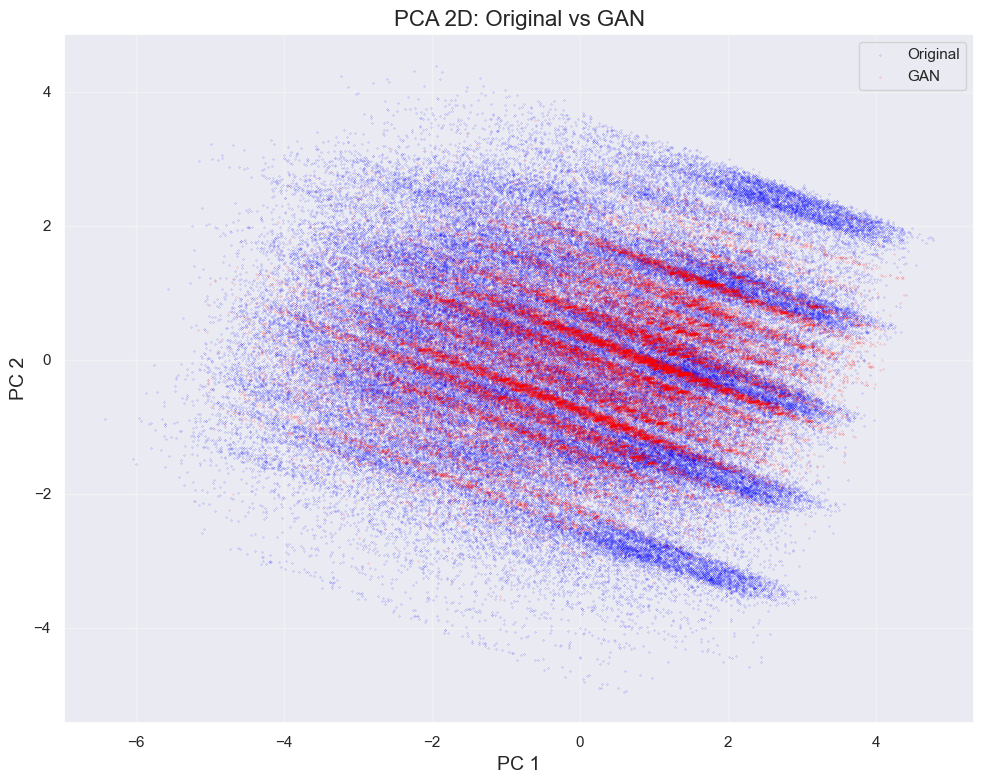

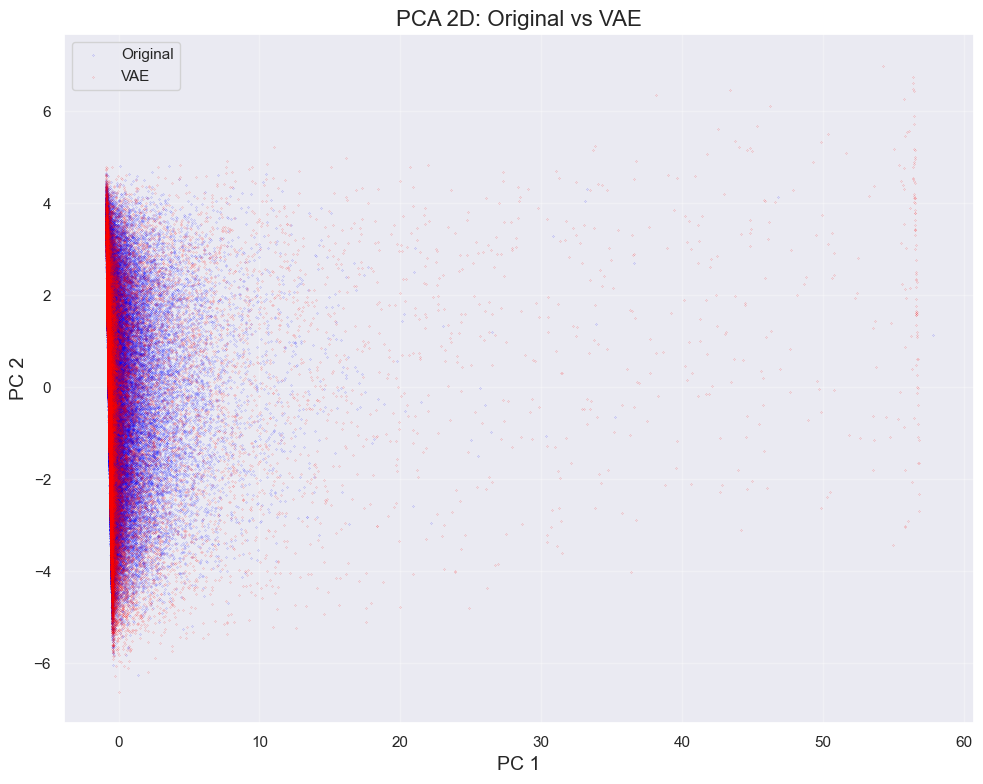

In [68]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Standardize original data once
X_orig = StandardScaler().fit_transform(real_df[num_cols].fillna(0))

# Prepare synthetic arrays (scaled with same scaler for comparability)
scaler = StandardScaler().fit(real_df[num_cols].fillna(0))
X_gan = scaler.transform(synthetic_data_gan[num_cols].fillna(0))
X_vae = scaler.transform(synthetic_data_vae[num_cols].fillna(0))

# Plotting function
def pca_compare(X_other, label):
    X_comb = np.vstack([X_orig, X_other])
    comps = PCA(n_components=2).fit_transform(X_comb)
    n = X_orig.shape[0]
    plt.figure(figsize=(10, 8))
    plt.scatter(comps[:n,0], comps[:n,1], s=0.01, c='blue', label='Original')
    plt.scatter(comps[n:,0], comps[n:,1], s=0.01, c='red', label=label)
    plt.title(f'PCA 2D: Original vs {label}', fontsize=16)
    plt.xlabel('PC 1', fontsize=14)
    plt.ylabel('PC 2', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generate the two plots
pca_compare(X_gan, 'GAN')
pca_compare(X_vae, 'VAE')

## 5. Discriminator

In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    confusion_matrix, classification_report
)

from sklearn.base import BaseEstimator, TransformerMixin

class GaussianNoise(BaseEstimator, TransformerMixin):
    def __init__(self, std=0.02, random_state=42):
        self.std = std
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X + self.rng.normal(0, self.std, X.shape)


def run_discriminator(
    real_df:   pd.DataFrame,
    synth_df:  pd.DataFrame,
    name:      str,
    *,
    n_components: int = 10,
    noise_std:    float = 0.02,
    random_state: int   = 42,
):
    # 1) label & stack
    real  = real_df.copy();  real ['__label'] = 0
    synth = synth_df.copy(); synth['__label'] = 1
    df    = pd.concat([real, synth], ignore_index=True)

    X = df.drop(columns='__label')
    y = df['__label']

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, stratify=y, test_size=0.30, random_state=random_state
    )

    # 2) column groups
    numeric_cols = X.select_dtypes(include=['number', 'bool']).columns.tolist()
    categoric_cols = [c for c in X.columns if c not in num_cols]

    # 3) preprocessing pipelines
    num_pipe = Pipeline([
        ('sc',    StandardScaler()),
        ('noise', GaussianNoise(std=noise_std, random_state=random_state))
    ])

    # convert every categorical column to string → avoids mixed-type error
    cat_pipe = Pipeline([
        ('to_str', FunctionTransformer(lambda x: x.astype(str), feature_names_out='one-to-one')),
        ('ohe',    OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    prep = ColumnTransformer(
        [('num', num_pipe, numeric_cols),
         ('cat', cat_pipe, categoric_cols)],
        remainder='drop'
    )

    # 4) full pipeline
    model = Pipeline([
        ('prep', prep),
        ('pca',  PCA(n_components=n_components, random_state=random_state)),
        ('clf',  LogisticRegression(max_iter=1000,
                                    C=0.1,            # strong L2 regularisation
                                    class_weight='balanced',
                                    random_state=random_state))
    ])

    # 5) train & report
    model.fit(X_tr, y_tr)
    y_pred  = model.predict(X_te)
    y_prob  = model.predict_proba(X_te)[:, 1]

    print(f"\n{name} Discriminator: ")
    print("Accuracy :", accuracy_score(y_te, y_pred))
    print("ROC AUC  :", roc_auc_score(y_te, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification Report:\n", classification_report(y_te, y_pred))


run_discriminator(real_df, synthetic_data_gan, "GAN")
run_discriminator(real_df, synthetic_data_vae, "VAE")


D:\stuff\math\diplom\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\stuff\math\diplom\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



GAN Discriminator: 
Accuracy : 0.6072831441654549
ROC AUC  : 0.6460251724100947
Confusion Matrix:
 [[16455 14624]
 [ 3472 11528]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.53      0.65     31079
           1       0.44      0.77      0.56     15000

    accuracy                           0.61     46079
   macro avg       0.63      0.65      0.60     46079
weighted avg       0.70      0.61      0.62     46079



D:\stuff\math\diplom\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



VAE Discriminator: 
Accuracy : 0.5378588945072593
ROC AUC  : 0.5237524351920375
Confusion Matrix:
 [[18470 12609]
 [ 8686  6314]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.59      0.63     31079
           1       0.33      0.42      0.37     15000

    accuracy                           0.54     46079
   macro avg       0.51      0.51      0.50     46079
weighted avg       0.57      0.54      0.55     46079



D:\stuff\math\diplom\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Household Power Consumption Dataset

## Препроцессинг та генерація даних

##### Препроцессинг датасету. Формування почасового датасету

In [3]:
# Loading dataset
raw = pd.read_csv(
    'datasets/household_power_consumption.csv',
    sep=';',
    dayfirst=True,
    na_values='?'
)
# Parse datetime explicitly to avoid FutureWarning
raw['dt'] = pd.to_datetime(
    raw['Date'].str.strip() + ' ' + raw['Time'].str.strip(),
    format='%d/%m/%Y %H:%M:%S',
    dayfirst=True,
    errors='coerce'
)
# Drop rows where parsing failed
df_power = raw.dropna(subset=['dt']).drop(columns=['Date', 'Time'])

# Aggregate to hourly sums and drop any remaining NaNs
df_hourly = (
    df_power
    .dropna()
    .set_index('dt')
    .resample('h')
    .sum()
)
# Extract one full year (2008)
year_df = df_hourly['2006-12-16':'2009-12-31']
print("Loaded hourly data shape:", year_df.shape)
display(year_df.head())

Loaded hourly data shape: (26671, 7)


Global_active_power  Global_reactive_power   Voltage  \
dt                                                                          
2006-12-16 17:00:00              152.024                  8.244   8447.18   
2006-12-16 18:00:00              217.932                  4.802  14074.81   
2006-12-16 19:00:00              204.014                  5.114  13993.95   
2006-12-16 20:00:00              196.114                  4.506  14044.29   
2006-12-16 21:00:00              183.388                  4.600  14229.52   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:00:00             651.6             0.0            19.0   
2006-12-16 18:00:00             936.0             0.0           403.0   
2006-12-16 19:00:00             870.2             0.0            86.0   
2006-12-16 20:00:00             835.0             0.0             0.0   
2006-12-16 21:00:00             782.8             0.0            25.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:00:00           607.0  
2006-12-16 18:00:00          1012.0  
2006-12-16 19:00:00          1001.0  
2006-12-16 20:00:00          1007.0  
2006-12-16 21:00:00          1033.0

##### Визначаємо метадані датасету для генерації

In [4]:
gen_meta_full = {
    'Global_active_power': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Global_reactive_power': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Voltage': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=2),
    'Global_intensity': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    'Sub_metering_1': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    'Sub_metering_2': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    'Sub_metering_3': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
}

##### Генерація даних за допомогою GAN та VAE нейромереж

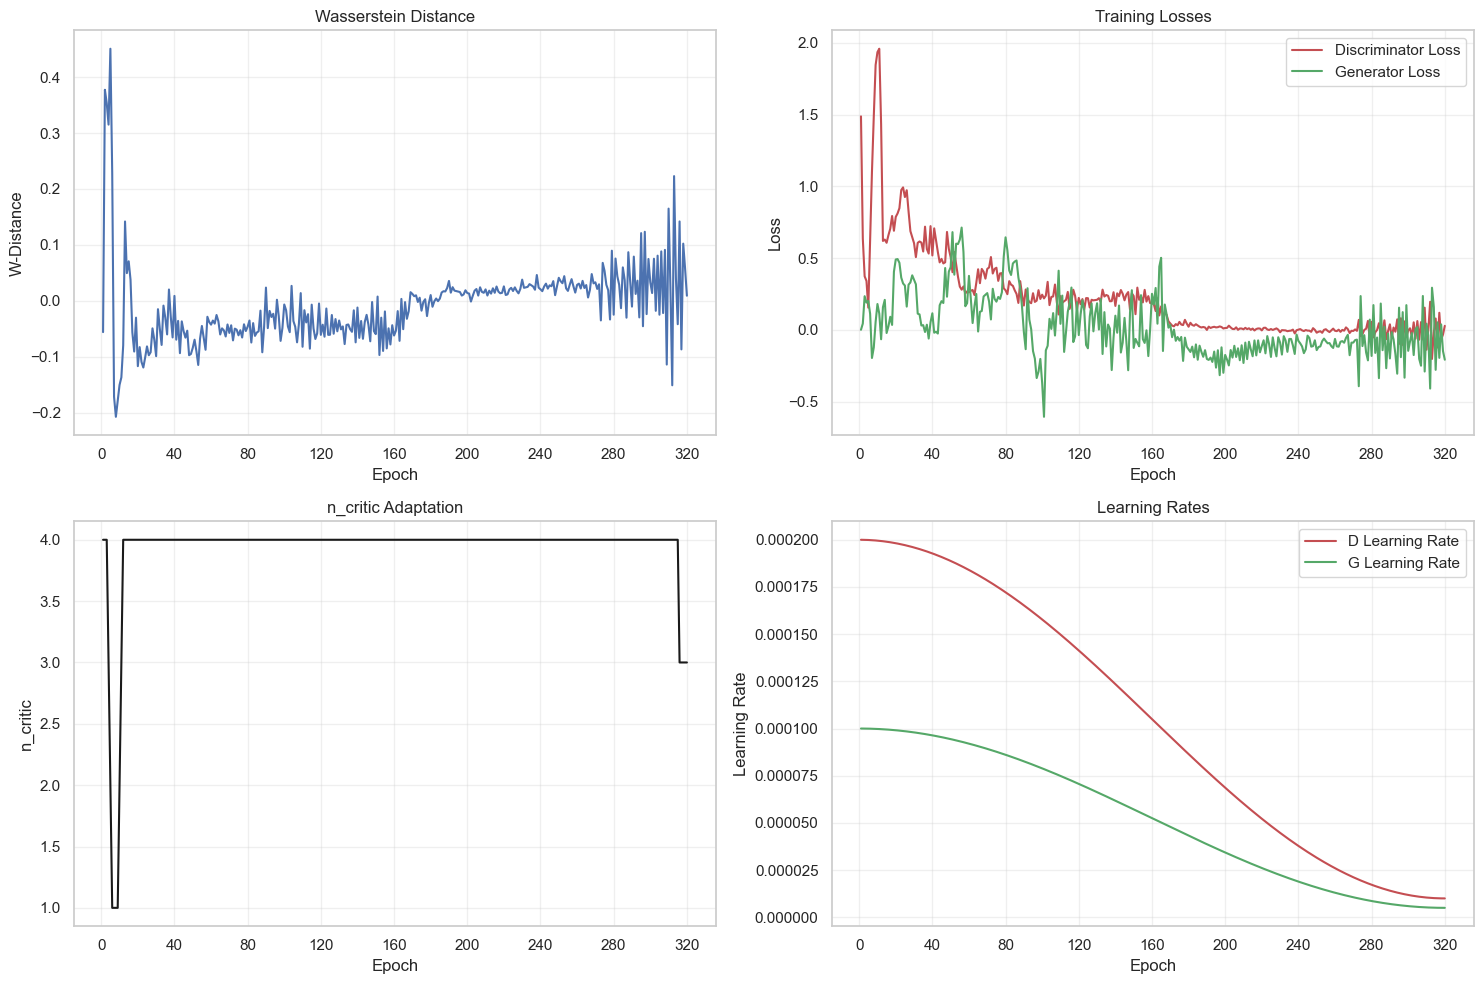

In [16]:
gan_full = GAN(year_df, gen_meta_full, GanConfig(epochs=320, patience=250))
gan_full.fit(verbose=True)
S_gan_full = gan_full.generate(len(year_df))

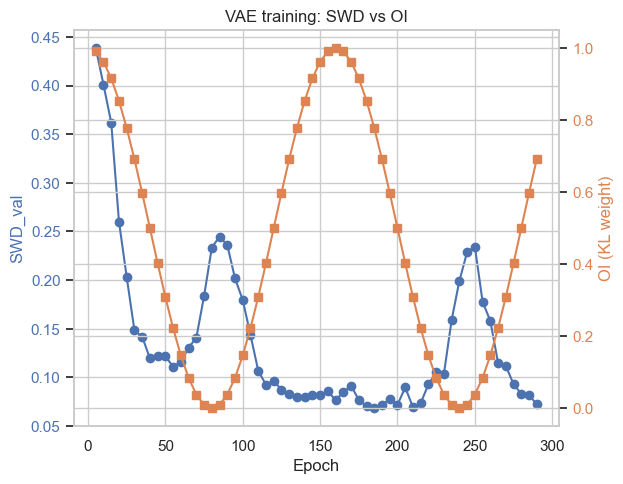

In [17]:
vae_full = VAE(year_df, gen_meta_full)
vae_full.fit(epochs=320, verbose=True)
S_vae_full = vae_full.generate(len(year_df))

In [23]:
year_df.to_csv('household-original.csv', index=False)
S_gan_full.to_csv('household-gan-synth.csv', index=False)
S_vae_full.to_csv('household-vae-synth.csv', index=False)

##### Статистичний аналіз синтетичних даних

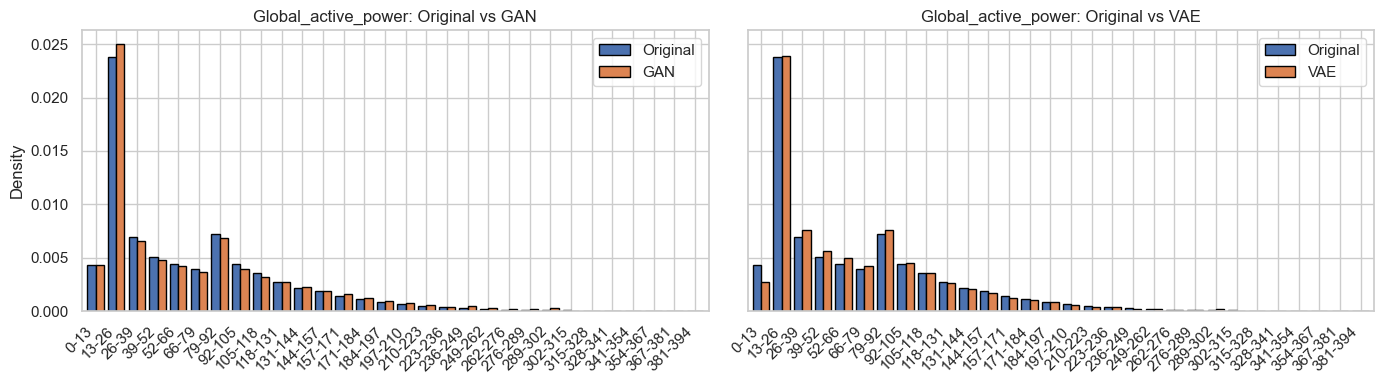

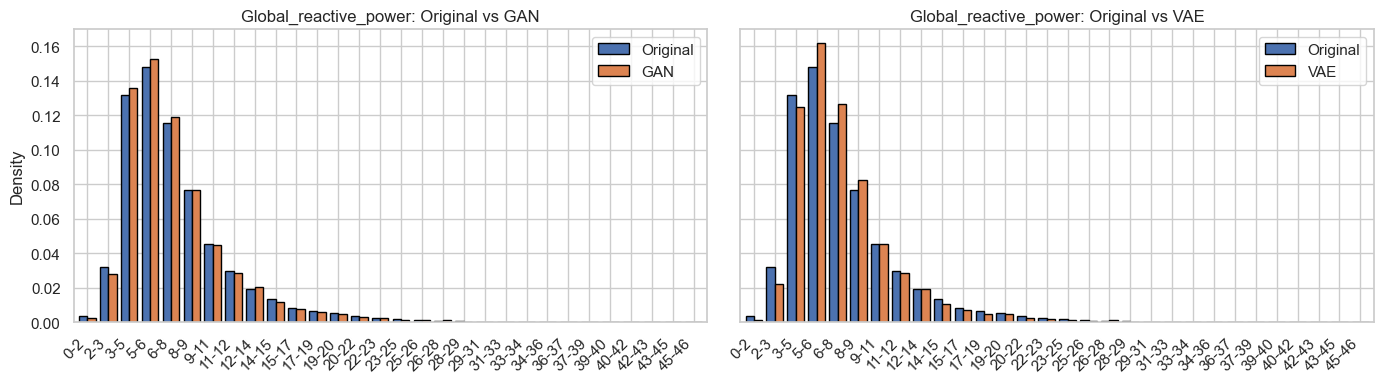

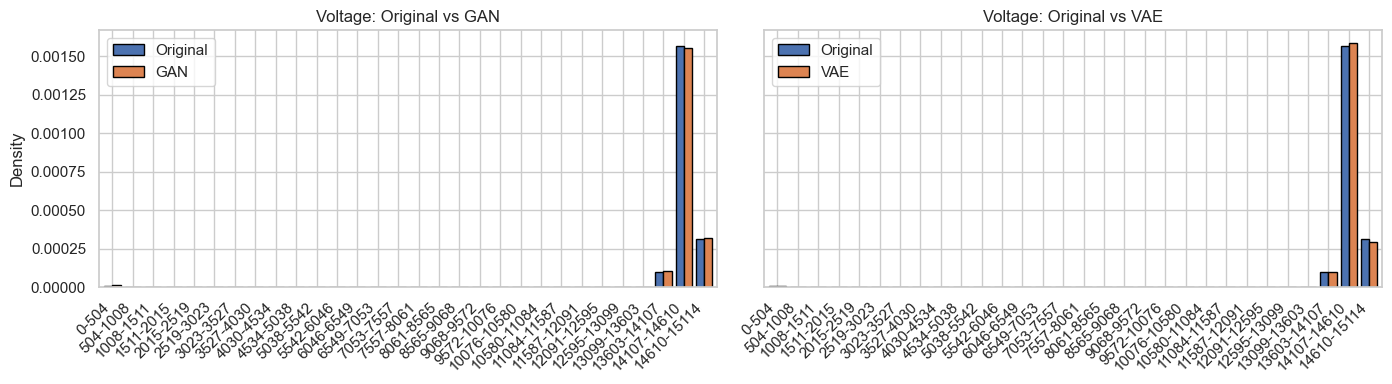

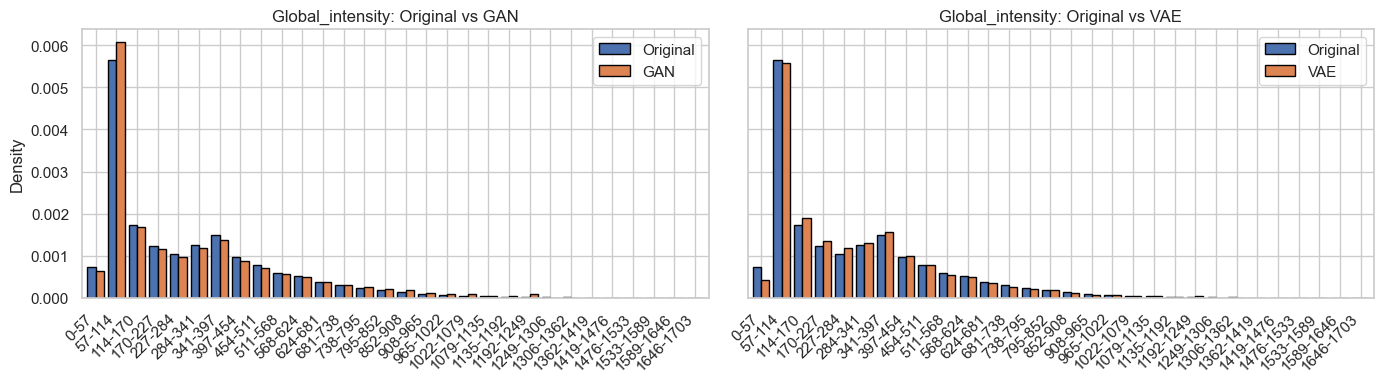

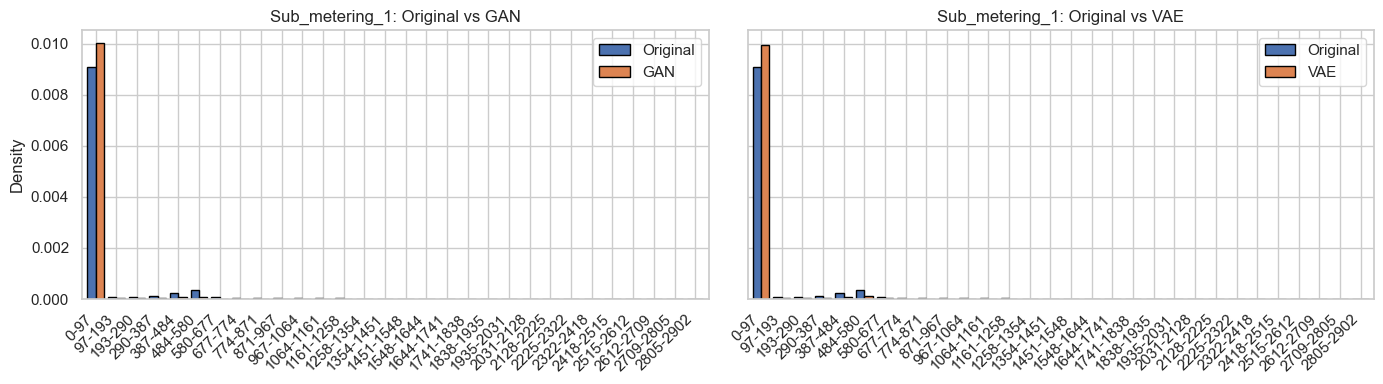

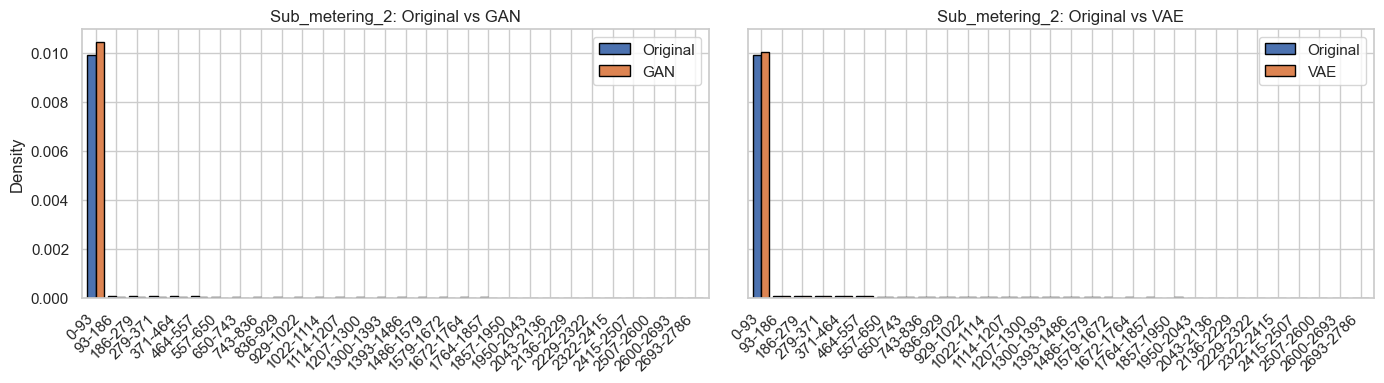

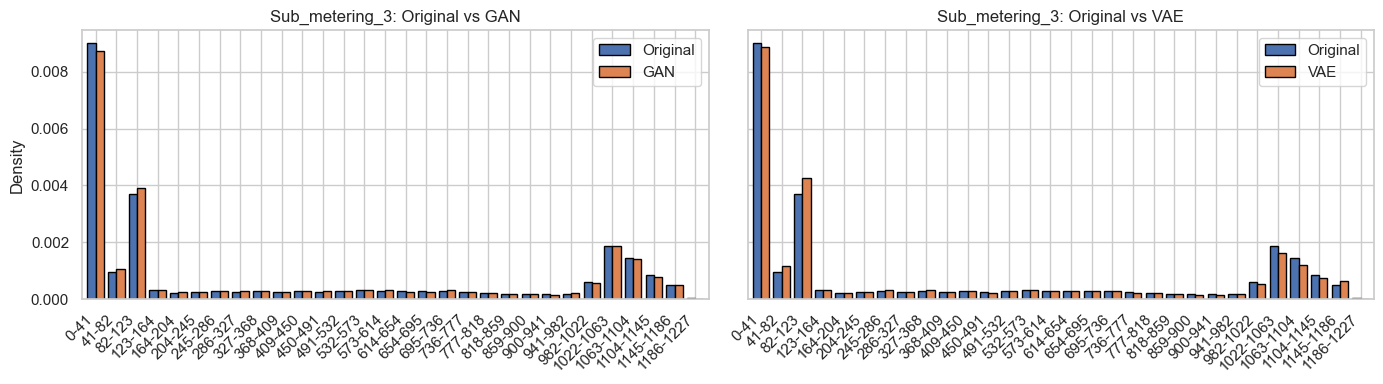

In [18]:
for col in list(gen_meta_full.keys()):
    orig_vals = year_df[col].dropna().values
    gan_vals  = S_gan_full[col].dropna().values
    vae_vals  = S_vae_full[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts,  _ = np.histogram(gan_vals,  bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins)-1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({'Original': orig_counts, 'GAN': gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({'Original': orig_counts, 'VAE': vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black')
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel('Density')

    df_ov.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.legend()
    plt.tight_layout()
    plt.show()

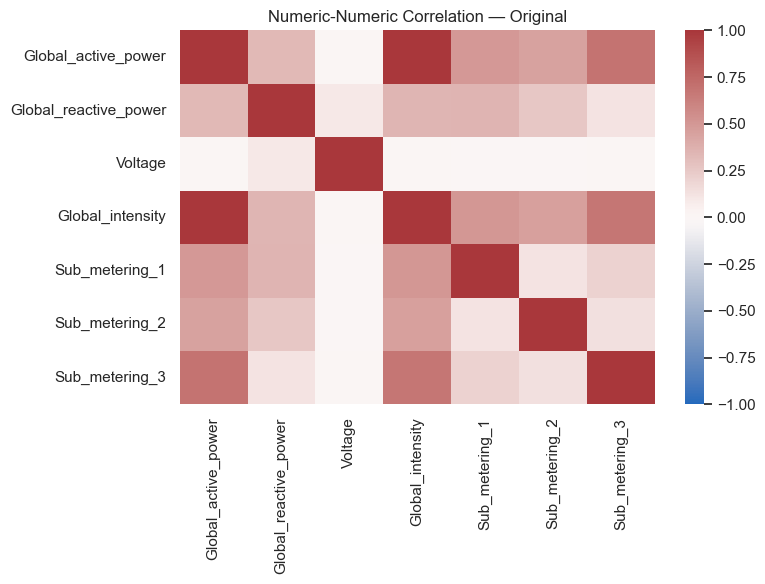

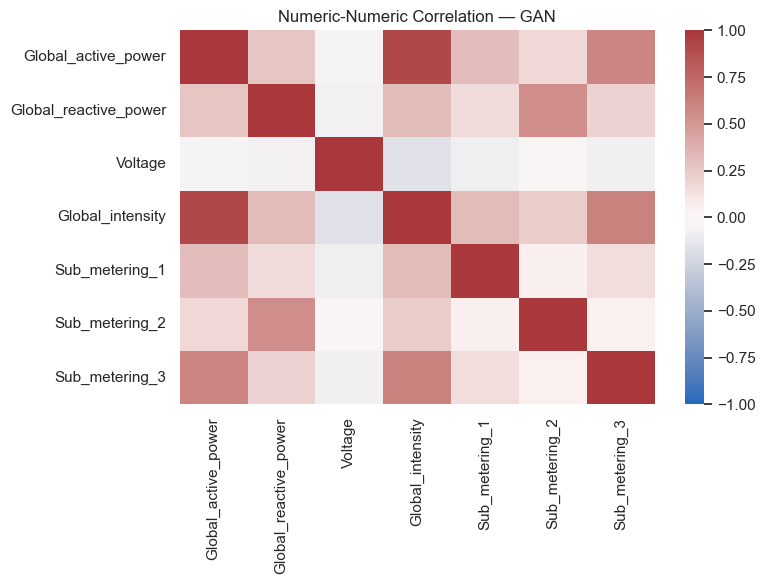

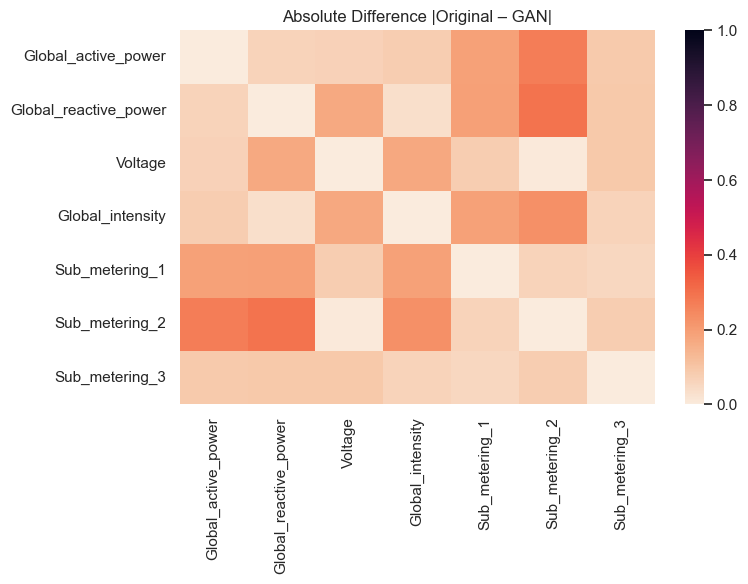

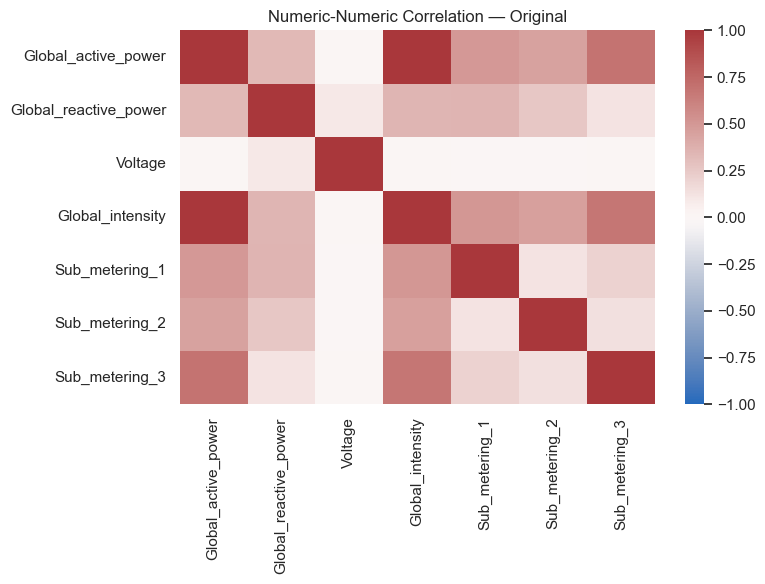

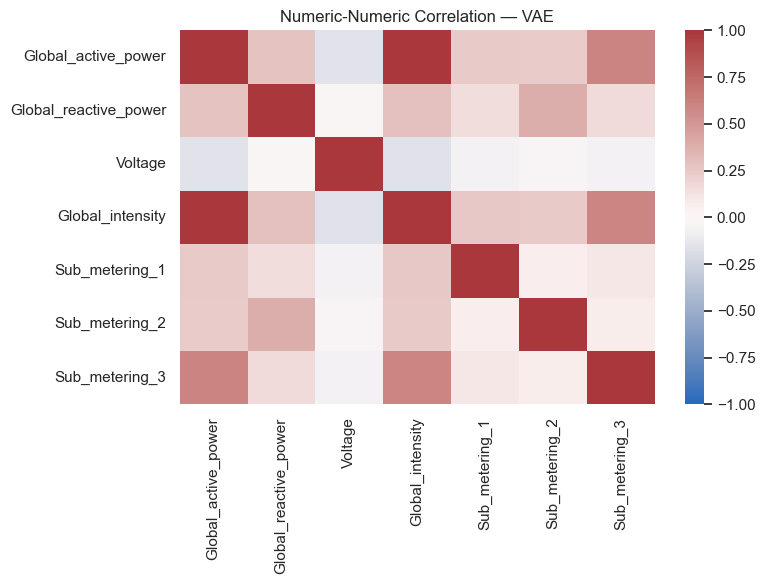

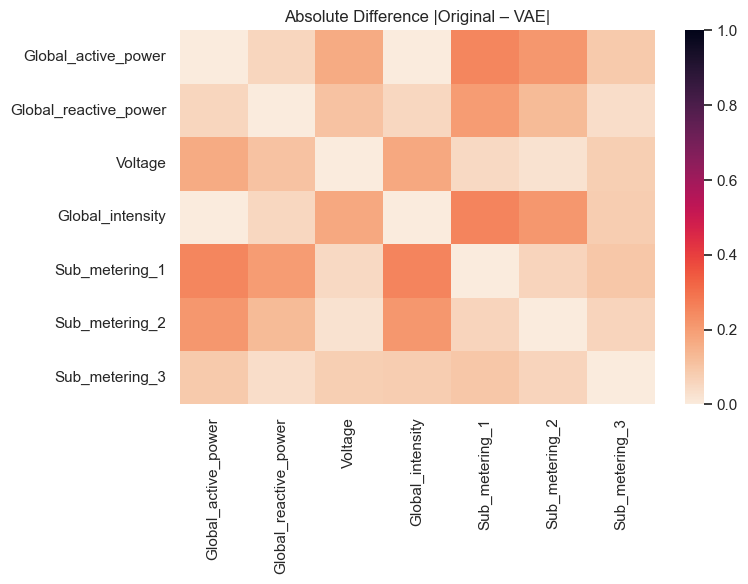

In [19]:
# Correlation matrixs
correlation_num_to_num_matrix_plot(year_df, S_gan_full, list(gen_meta_full.keys()), "GAN")
correlation_num_to_num_matrix_plot(year_df, S_vae_full, list(gen_meta_full.keys()), "VAE")

## Change‑Point Detection on Power Consumption

In [20]:
display(year_df)

Global_active_power  Global_reactive_power   Voltage  \
dt                                                                          
2006-12-16 17:00:00              152.024                  8.244   8447.18   
2006-12-16 18:00:00              217.932                  4.802  14074.81   
2006-12-16 19:00:00              204.014                  5.114  13993.95   
2006-12-16 20:00:00              196.114                  4.506  14044.29   
2006-12-16 21:00:00              183.388                  4.600  14229.52   
...                                  ...                    ...       ...   
2009-12-31 19:00:00              183.772                 11.218  14234.90   
2009-12-31 20:00:00              170.550                  9.526  14267.67   
2009-12-31 21:00:00              172.522                 12.936  14198.49   
2009-12-31 22:00:00              122.062                  8.088  14274.83   
2009-12-31 23:00:00              101.430                  5.922  14404.28   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:00:00             651.6             0.0            19.0   
2006-12-16 18:00:00             936.0             0.0           403.0   
2006-12-16 19:00:00             870.2             0.0            86.0   
2006-12-16 20:00:00             835.0             0.0             0.0   
2006-12-16 21:00:00             782.8             0.0            25.0   
...                               ...             ...             ...   
2009-12-31 19:00:00             770.8             0.0             7.0   
2009-12-31 20:00:00             714.0             0.0             0.0   
2009-12-31 21:00:00             726.0             0.0            21.0   
2009-12-31 22:00:00             511.2             0.0            32.0   
2009-12-31 23:00:00             417.4             0.0             0.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:00:00           607.0  
2006-12-16 18:00:00          1012.0  
2006-12-16 19:00:00          1001.0  
2006-12-16 20:00:00          1007.0  
2006-12-16 21:00:00          1033.0  
...                             ...  
2009-12-31 19:00:00          1074.0  
2009-12-31 20:00:00          1078.0  
2009-12-31 21:00:00          1123.0  
2009-12-31 22:00:00          1079.0  
2009-12-31 23:00:00          1099.0  

[26671 rows x 7 columns]

C:\Users\maksp\AppData\Local\Temp\ipykernel_7212\2157078538.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return ser.resample("1H").mean().interpolate()


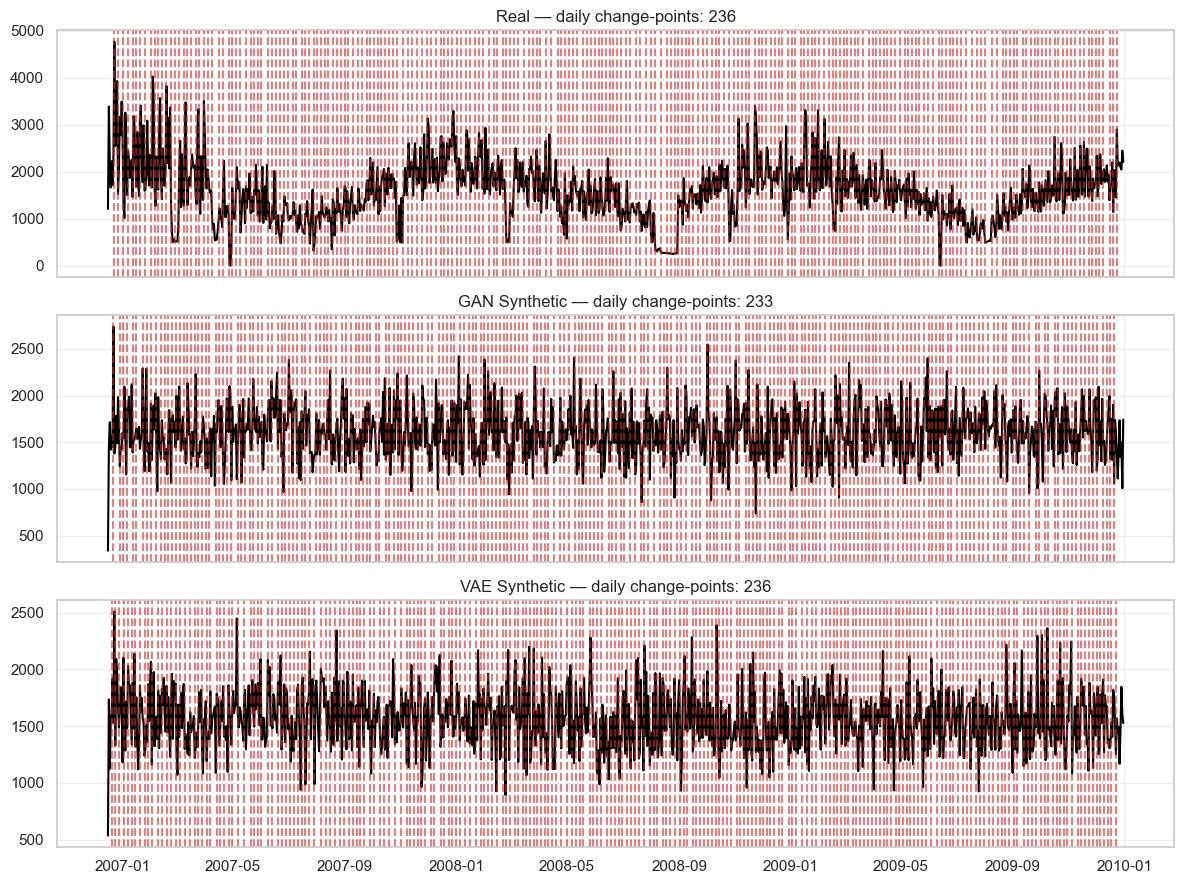

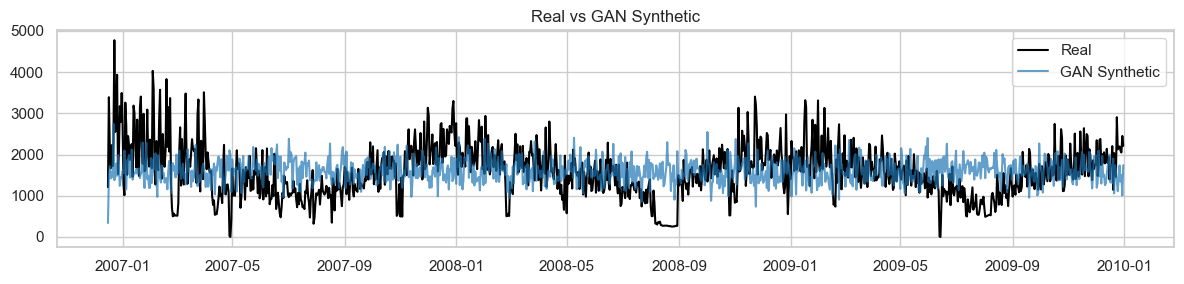

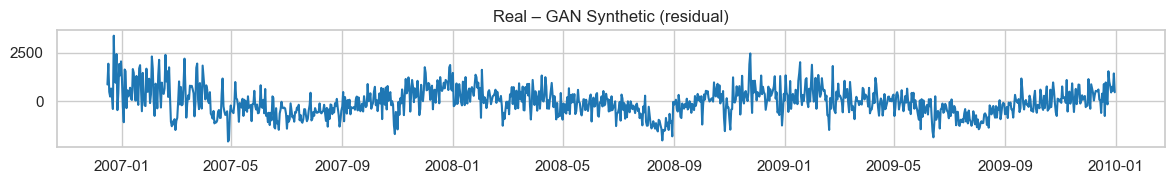

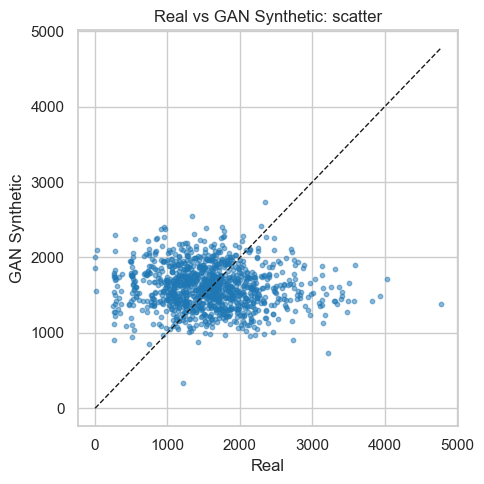

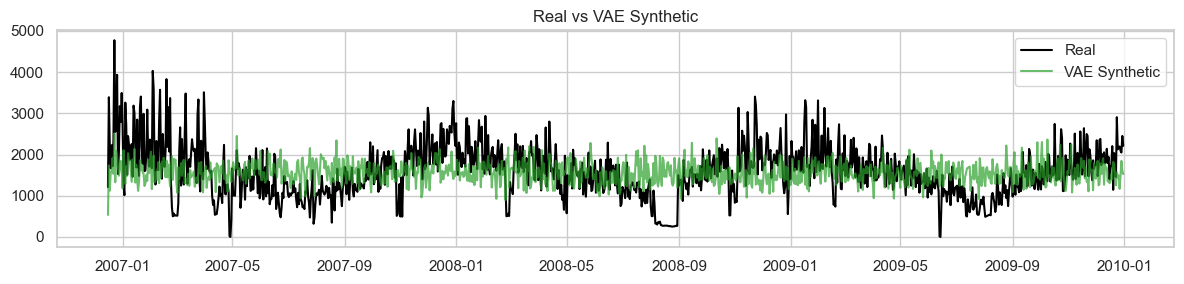

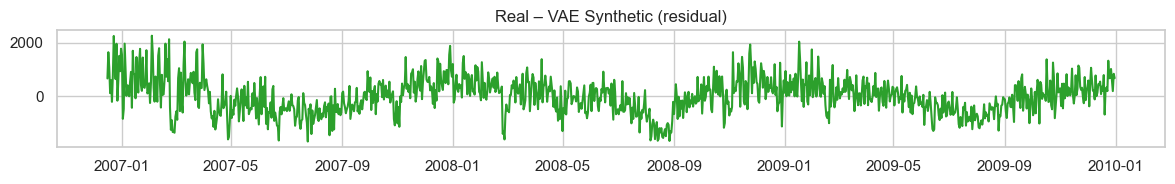

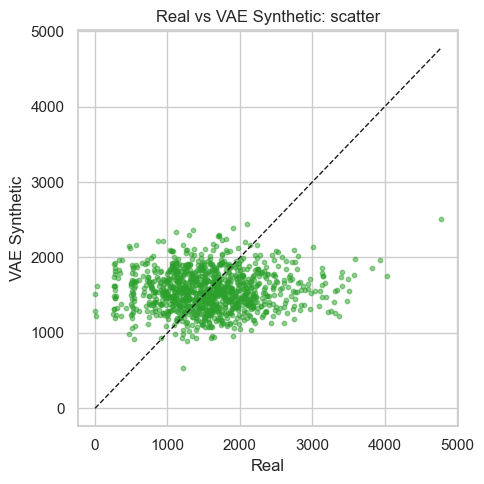

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from pandas.api.types import is_datetime64_any_dtype as is_dt

def make_hourly_series(df, power_col="Global_active_power", master_idx=None):
    """Turn df into a regularly‐spaced hourly Series (mean and interpolate)."""
    # find or build a datetime index
    if any(is_dt(df[c]) for c in df.columns):
        c = next(c for c in df.columns if is_dt(df[c]))
        idx = pd.to_datetime(df[c])
    elif {"Date", "Time"}.issubset(df.columns):
        idx = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True)
    elif is_dt(df.index):
        idx = df.index
    else:
        if master_idx is None:
            raise ValueError("Synthetic data needs a master DatetimeIndex")
        idx = master_idx[: len(df)]
    # build, sort, resample, interpolate
    ser = pd.Series(df[power_col].values, index=idx).sort_index()
    return ser.resample("1H").mean().interpolate()

def detect_change_points(
    series: pd.Series,
    freq: str     = 'D',
    agg: str      = 'sum',
    model: str    = 'l2',
    pen: float    = 10,
    min_size: int = 4,
    jump: int     = 1
):
    """
    1) Resample `series` at `freq` with agg ('sum' or 'mean'),
    2) Run PELT and return (resampled_series, list_of_timestamps).
    """
    # Resample + interp
    if series.index.freqstr != freq:
        if agg == 'sum':
            s = series.resample(freq).sum()
        else:
            s = series.resample(freq).mean()
        s = s.interpolate()
    else:
        s = series.copy()
    # PELT
    algo = rpt.Pelt(model=model, min_size=min_size, jump=jump)
    bps  = algo.fit(s.values).predict(pen=pen)
    # convert to timestamps
    times = [s.index[i] for i in bps if i < len(s)]
    return s, times

def compare_series(real, synth, label,
                   color_real='black', color_synth='tab:blue'):
    """Overlay / residual / scatter plots for real vs. synthetic."""
    # 1) overlay
    plt.figure(figsize=(12,3))
    plt.plot(real.index, real,   label='Real',  color=color_real)
    plt.plot(synth.index, synth, label=label,   color=color_synth, alpha=0.7)
    plt.title(f"Real vs {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) residual
    diff = real - synth
    plt.figure(figsize=(12,2))
    plt.plot(diff.index, diff, color=color_synth)
    plt.title(f"Real – {label} (residual)")
    plt.tight_layout()
    plt.show()

    # 3) scatter
    plt.figure(figsize=(5,5))
    plt.scatter(real.values, synth.values, s=10, alpha=0.5, color=color_synth)
    lims = (min(real.min(), synth.min()), max(real.max(), synth.max()))
    plt.plot(lims, lims, 'k--', lw=1)
    plt.xlabel("Real"); plt.ylabel(label)
    plt.title(f"Real vs {label}: scatter")
    plt.tight_layout()
    plt.show()

real_ts = make_hourly_series(year_df)
gan_ts  = make_hourly_series(S_gan_full, master_idx=real_ts.index)
vae_ts  = make_hourly_series(S_vae_full, master_idx=real_ts.index)

# 2) convert to daily (sum) + detect daily change-points
real_daily, real_bps = detect_change_points(real_ts, freq='D', agg='sum', pen=5, jump=1)
gan_daily,  gan_bps  = detect_change_points(gan_ts,  freq='D', agg='sum', pen=5, jump=1)
vae_daily,  vae_bps  = detect_change_points(vae_ts,  freq='D', agg='sum', pen=5, jump=1)

# 3) plot daily change-points side by side
fig, axes = plt.subplots(3,1, figsize=(12,9), sharex=True)
for ax, (series, bps, title) in zip(axes, [
    (real_daily, real_bps, 'Real'),
    (gan_daily,  gan_bps,  'GAN Synthetic'),
    (vae_daily,  vae_bps,  'VAE Synthetic')
]):
    ax.plot(series.index, series, color='black')
    for t in bps[:-1]:
        ax.axvline(t, ls='--', c='tab:red', alpha=0.6)
    ax.set_title(f"{title} — daily change-points: {len(bps)-1}")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) compare real vs GAN and real vs VAE
compare_series(real_daily, gan_daily, "GAN Synthetic", color_synth='tab:blue')
compare_series(real_daily, vae_daily, "VAE Synthetic", color_synth='tab:green')

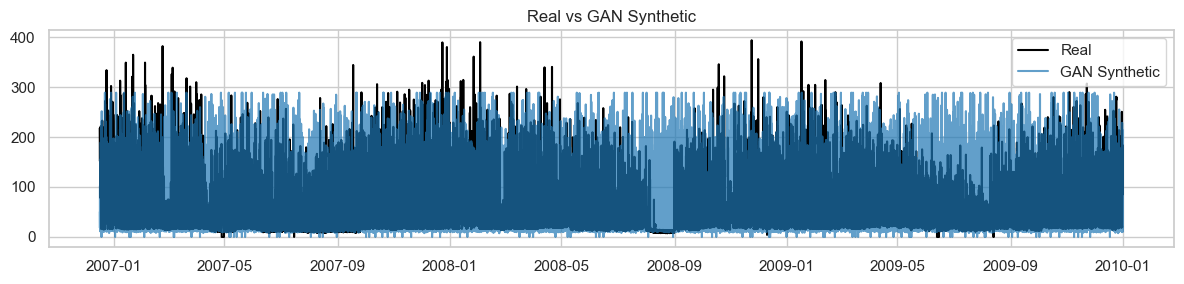

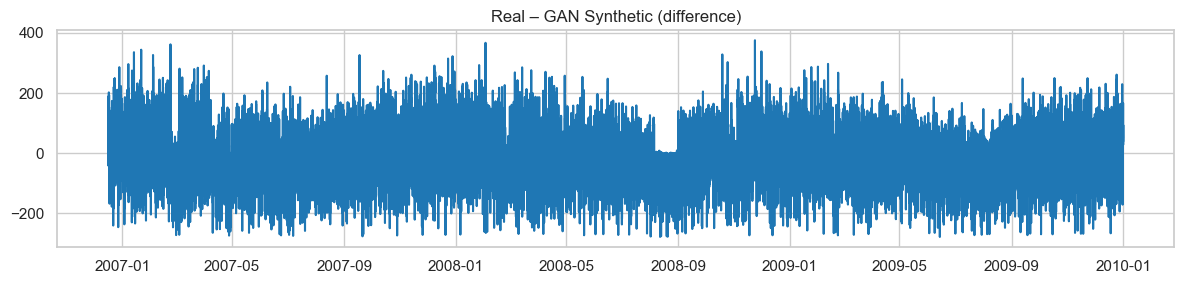

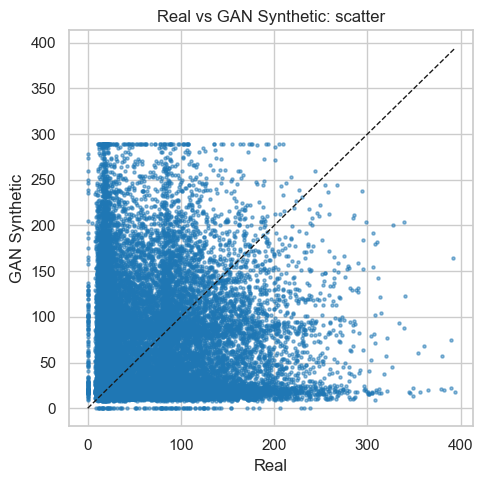

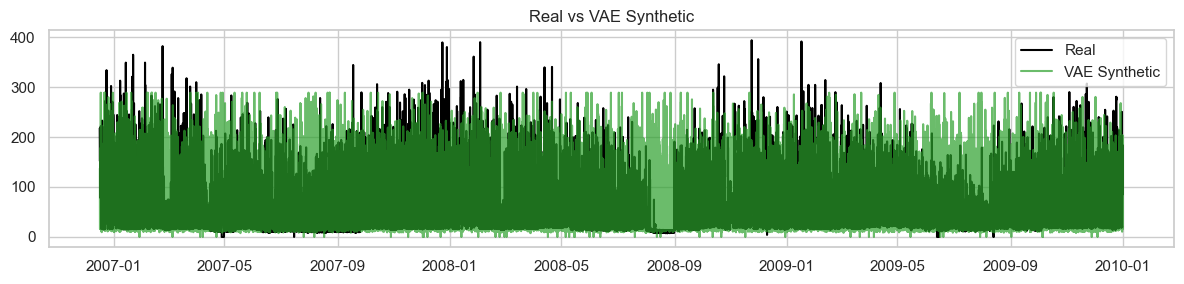

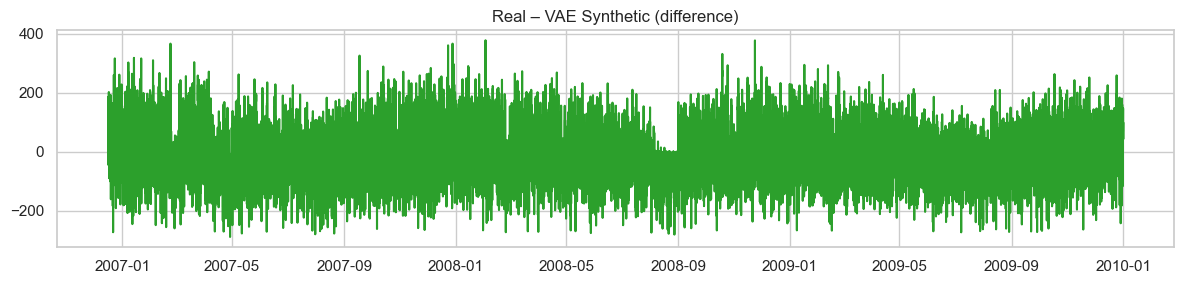

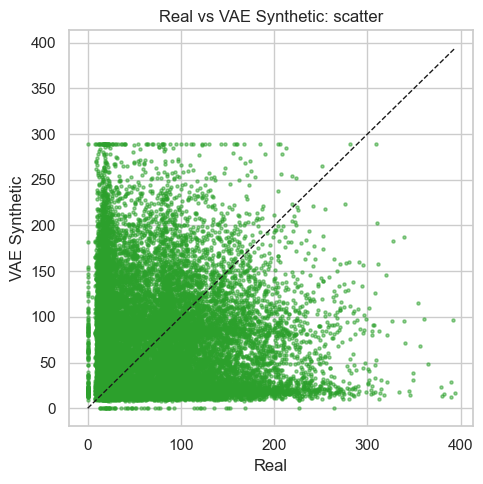

In [22]:
import matplotlib.pyplot as plt

def compare_series(real, synth, label, color_real="k", color_synth="C0"):
    # 1) Time-series overlay
    plt.figure(figsize=(12,3))
    plt.plot(real.index, real,   label="Real",  color=color_real,  alpha=1.0)
    plt.plot(synth.index, synth, label=label,   color=color_synth, alpha=0.7)
    plt.title(f"Real vs {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Difference (residual) plot
    diff = real - synth
    plt.figure(figsize=(12,3))
    plt.plot(diff.index, diff, color=color_synth)
    plt.title(f"Real – {label} (difference)")
    plt.tight_layout()
    plt.show()

    # 3) Scatter plot original vs synthetic
    plt.figure(figsize=(5,5))
    plt.scatter(real.values, synth.values, s=5, alpha=0.5, color=color_synth)
    lims = (
        min(real.min(), synth.min()),
        max(real.max(), synth.max())
    )
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel("Real")
    plt.ylabel(label)
    plt.title(f"Real vs {label}: scatter")
    plt.tight_layout()
    plt.show()

# slice real
real_for_gan = real_ts.iloc[: len(gan_ts)]
real_for_vae = real_ts.iloc[: len(vae_ts)]

# compare
compare_series(real_for_gan, gan_ts,  "GAN Synthetic", color_real="black", color_synth="tab:blue")
compare_series(real_for_vae, vae_ts,  "VAE Synthetic", color_real="black", color_synth="tab:green")


## Sliding‑Window Classification (Peak vs. Normal)

In [12]:
from sklearn.ensemble import RandomForestClassifier

W = 24
data = year_df['Global_active_power'].values
win_real = np.stack([data[i:i+W] for i in range(len(data)-W+1)])
thr = np.percentile(win_real.max(axis=1), 90)
y_real = (win_real.max(axis=1) > thr).astype(int)
print(f'Real peaks: {y_real.sum()}, normals: {len(y_real)-y_real.sum()}')

# Build synthetic windows aligned to real count
build = lambda x: np.stack([x[i:i+W] for i in range(len(x)-W+1)])
win_gan = build(S_gan_full['Global_active_power'].values)[:len(win_real)]
win_vae = build(S_vae_full['Global_active_power'].values)[:len(win_real)]

# Classification accuracy
def class_acc(r, s, y):
    X = np.vstack([r, s])
    y_full = np.hstack([y, np.zeros(len(r),int)])
    Xtr,Xte,yt,ye = train_test_split(X, y_full, stratify=y_full, test_size=0.2, random_state=42)
    m = RandomForestClassifier(n_estimators=100, random_state=42).fit(Xtr, yt)
    return m.score(Xte, ye)
acc_gan = class_acc(win_real, win_gan, y_real)
acc_vae = class_acc(win_real, win_vae, y_real)
print(f'Accuracy GAN: {acc_gan:.2%}, VAE: {acc_vae:.2%}')

# Visualize sample windows: overlay first three
n_samples = 3
plt.figure(figsize=(10,6))
for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(win_real[i], label='Real', linewidth=2)
    plt.plot(win_gan[i], '--', label='GAN')
    plt.plot(win_vae[i], ':', label='VAE')
    plt.legend(loc='upper right'); plt.ylabel('Power')
plt.xlabel('Hour index')
plt.suptitle('Sample Sliding Windows: Real vs GAN vs VAE', y=1.02)
plt.tight_layout(); plt.show()

Real peaks: 2642, normals: 24006


NameError: name 'train_test_split' is not defined

## 8. Short‑Term Forecasting with ARIMA

In [175]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

dly = df_power.set_index('dt').resample('D').sum().reset_index().rename(columns={'Global_active_power':'Value'})
train = dly.set_index('dt')['Value'][:-180]
train.index = pd.DatetimeIndex(train.index, freq='D')
test = dly.set_index('dt')['Value'][-180:]
test.index = pd.DatetimeIndex(test.index, freq='D')

# Synthetic daily series with frequency
gan_daily = S_gan_full.set_index(year_df.index)['Global_active_power'].resample('D').sum().rename('Value')
gan_daily.index = pd.DatetimeIndex(gan_daily.index, freq='D')
vae_daily = S_vae_full.set_index(year_df.index)['Global_active_power'].resample('D').sum().rename('Value')
vae_daily.index = pd.DatetimeIndex(vae_daily.index, freq='D')

# Forecast helper
def forecast_mae(train_s, syn_s, label):
    future = syn_s.iloc[:60]
    future.index = pd.date_range(start=train_s.index[-1] + pd.Timedelta(days=1), periods=len(future), freq='D')
    aug = pd.concat([train_s, future])
    model = ARIMA(aug, order=(5,1,0)).fit()
    preds = model.predict(start=test.index[0], end=test.index[-1])
    print(f"MAE ({label} augment):", (preds - test).abs().mean())

forecast_mae(train, gan_daily, 'GAN')
forecast_mae(train, vae_daily, 'VAE')
# Real-only baseline
model_real = ARIMA(train, order=(5,1,0)).fit()
preds_real = model_real.predict(start=test.index[0], end=test.index[-1])
print('MAE (Real-only):', (preds_real - test).abs().mean())

# 1) Time-series overlay (hourly)
plt.figure(figsize=(12, 5))
plt.plot(year_df.index, year_df['Global_active_power'], label='Real')
plt.plot(year_df.index, S_gan_full['Global_active_power'], label='GAN Synthetic', alpha=0.7)
plt.plot(year_df.index, S_vae_full['Global_active_power'], label='VAE Synthetic', alpha=0.7)
plt.title('Hourly Global Active Power: Real vs Synthetic')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Distribution comparison (histograms)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axes[0].hist(year_df['Global_active_power'], bins=50)
axes[0].set_title('Real')
axes[1].hist(S_gan_full['Global_active_power'], bins=50)
axes[1].set_title('GAN Synthetic')
axes[2].hist(S_vae_full['Global_active_power'], bins=50)
axes[2].set_title('VAE Synthetic')
fig.suptitle('Distribution of Global Active Power')
plt.tight_layout()
plt.show()

# 3) Autocorrelation of the real series
plt.figure(figsize=(8, 4))
autocorrelation_plot(year_df['Global_active_power'])
plt.title('Autocorrelation (Real Series)')
plt.show()

# 4) Correlation heatmap of all variables (real vs synthetic)
#    (using only matplotlib — no seaborn)
def plot_corr(df, title):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.matshow(corr, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=90, ha='left')
    ax.set_yticks(range(len(corr.columns)))
    ax.set_yticklabels(corr.columns)
    plt.title(title, pad=20)
    plt.tight_layout()
    plt.show()

plot_corr(year_df, 'Real Data Correlations')
plot_corr(S_gan_full.set_index(year_df.index), 'GAN Synthetic Correlations')
plot_corr(S_vae_full.set_index(year_df.index), 'VAE Synthetic Correlations')


MAE (GAN augment): 425.53838207457125
MAE (VAE augment): 424.8428832125122
MAE (Real-only): 464.71655067765556
